# Useful Resources

- https://colab.research.google.com/github/bentrevett/pytorch-pos-tagging/blob/master/1_bilstm.ipynb

# Prepare

In [1]:
!pip install -q tqdm
!pip install -q conllu
!pip install -q seaborn
!pip install -q datasets
!pip install -q scikit-learn
!pip install -q pytorch_lightning
!pip install -q git+https://github.com/MagedSaeed/tkseem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.7 MB/s eta

In [2]:
import re
import os
import random
import string
import shutil
from pathlib import Path
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import torchmetrics

from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import LightningModule,Trainer
from pytorch_lightning.callbacks import EarlyStopping,LearningRateMonitor,ModelCheckpoint,Callback

import datasets
import seaborn as sns
import matplotlib.pyplot as plt


import tkseem as tk
from tqdm.auto import tqdm

In [3]:
seed = 42

In [4]:
# random.seed(seed)     # python random generator
# np.random.seed(seed)  # numpy random generator

# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

seed_everything(seed)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [5]:
tqdm.pandas()

In [6]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load and explore the dataset

In [7]:
train_dataset = datasets.concatenate_datasets([
  # datasets.load_dataset("universal_dependencies", "en_esl")['train'], # text is not there
  datasets.load_dataset("universal_dependencies", "en_ewt")['train'],
  # datasets.load_dataset("universal_dependencies", "en_gum")['train'],
  # datasets.load_dataset("universal_dependencies", "en_gumreddit")['train'], # text is not there
  # datasets.load_dataset("universal_dependencies", "en_lines")['train'],
  # datasets.load_dataset("universal_dependencies", "en_partut")['train'],
  # datasets.load_dataset("universal_dependencies", "en_pronouns")['train'], # does not have a train split
  # datasets.load_dataset("universal_dependencies", "en_pud")['train'], # does not have a train split
])
train_dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2002 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2077 [00:00<?, ? examples/s]

Dataset universal_dependencies downloaded and prepared to /root/.cache/huggingface/datasets/universal_dependencies/en_ewt/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 12543
})

In [8]:
validation_dataset = datasets.concatenate_datasets([
  # datasets.load_dataset("universal_dependencies", "en_esl")['train'], # text is not there
  datasets.load_dataset("universal_dependencies", "en_ewt")['validation'],
  # datasets.load_dataset("universal_dependencies", "en_gum")['train'],
  # datasets.load_dataset("universal_dependencies", "en_gumreddit")['train'], # text is not there
  # datasets.load_dataset("universal_dependencies", "en_lines")['train'],
  # datasets.load_dataset("universal_dependencies", "en_partut")['train'],
  # datasets.load_dataset("universal_dependencies", "en_pronouns")['train'], # does not have a train split
  # datasets.load_dataset("universal_dependencies", "en_pud")['train'], # does not have a train split
])
validation_dataset

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 2002
})

In [9]:
test_dataset = datasets.concatenate_datasets([
  # datasets.load_dataset("universal_dependencies", "en_esl")['test'],
  datasets.load_dataset("universal_dependencies", "en_ewt")['test'],
  # datasets.load_dataset("universal_dependencies", "en_gum")['test'],
  # datasets.load_dataset("universal_dependencies", "en_gumreddit")['test'],
  # datasets.load_dataset("universal_dependencies", "en_lines")['test'],
  # datasets.load_dataset("universal_dependencies", "en_partut")['test'],
  # datasets.load_dataset("universal_dependencies", "en_pronouns")['test'],
  # datasets.load_dataset("universal_dependencies", "en_pud")['test'],
])
test_dataset

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['idx', 'text', 'tokens', 'lemmas', 'upos', 'xpos', 'feats', 'head', 'deprel', 'deps', 'misc'],
    num_rows: 2077
})

Converting to Pandas and droping duplicates

In [10]:
train_dataset = train_dataset.to_pandas()
train_dataset

idx  \
0      weblog-juancole.com_juancole_20051126063000_EN...   
1      weblog-juancole.com_juancole_20051126063000_EN...   
2      weblog-juancole.com_juancole_20051126063000_EN...   
3      weblog-juancole.com_juancole_20051126063000_EN...   
4      weblog-juancole.com_juancole_20051126063000_EN...   
...                                                  ...   
12538                                reviews-319816-0025   
12539                                reviews-319816-0026   
12540                                reviews-319816-0027   
12541                                reviews-319816-0028   
12542                                reviews-319816-0029   

                                                    text  \
0      Al-Zaman : American forces killed Shaikh Abdul...   
1      [This killing of a respected cleric will be ca...   
2      DPA: Iraqi authorities announced that they had...   
3      Two of them were being run by 2 officials of t...   
4      The MoI in Iraq is equivalent to the US FBI, s...   
...                                                  ...   
12538  Of course, they couldn't call him either to as...   
12539  On Monday I called and again it was a big to-d...   
12540  Supposedly they will be holding it for me this...   
12541  The employees at this Sear's are completely ap...   
12542  I will never return there again (and now have ...   

                                                  tokens  \
0      [Al, -, Zaman, :, American, forces, killed, Sh...   
1      [[, This, killing, of, a, respected, cleric, w...   
2      [DPA, :, Iraqi, authorities, announced, that, ...   
3      [Two, of, them, were, being, run, by, 2, offic...   
4      [The, MoI, in, Iraq, is, equivalent, to, the, ...   
...                                                  ...   
12538  [Of, course, ,, they, couldn't, could, n't, ca...   
12539  [On, Monday, I, called, and, again, it, was, a...   
12540  [Supposedly, they, will, be, holding, it, for,...   
12541  [The, employees, at, this, Sear's, are, comple...   
12542  [I, will, never, return, there, again, (, and,...   

                                                  lemmas  \
0      [Al, -, Zaman, :, american, force, kill, Shaik...   
1      [[, this, killing, of, a, respected, cleric, w...   
2      [DPA, :, iraqi, authority, announce, that, the...   
3      [two, of, they, be, be, run, by, 2, official, ...   
4      [the, MoI, in, Iraq, be, equivalent, to, the, ...   
...                                                  ...   
12538  [of, course, ,, they, _, could, not, call, he,...   
12539  [on, Monday, I, call, and, again, it, be, a, b...   
12540  [supposedly, they, will, be, hold, it, for, I,...   
12541  [the, employee, at, this, Sears, be, completel...   
12542  [I, will, never, return, there, again, (, and,...   

                                                    upos  \
0      [10, 1, 10, 1, 6, 0, 16, 10, 10, 10, 1, 10, 1,...   
1      [1, 8, 0, 2, 8, 6, 0, 17, 17, 16, 11, 0, 2, 0,...   
2      [10, 1, 6, 0, 16, 5, 11, 17, 16, 2, 3, 6, 0, 1...   
3      [3, 2, 11, 17, 17, 16, 2, 3, 0, 2, 8, 10, 2, 8...   
4      [8, 10, 2, 10, 17, 6, 2, 8, 10, 10, 1, 14, 11,...   
...                                                  ...   
12538  [14, 14, 1, 11, 13, 17, 7, 16, 11, 14, 7, 16, ...   
12539  [2, 10, 11, 16, 9, 14, 11, 17, 8, 6, 0, 1, 0, ...   
12540  [14, 11, 17, 17, 16, 11, 2, 11, 8, 0, 1, 9, 13...   
12541  [8, 0, 2, 8, 10, 17, 14, 6, 9, 11, 13, 17, 7, ...   
12542  [11, 17, 14, 16, 14, 14, 1, 9, 14, 16, 8, 6, 0...   

                                                    xpos  \
0      [NNP, HYPH, NNP, :, JJ, NNS, VBD, NNP, NNP, NN...   
1      [-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...   
2      [NNP, :, JJ, NNS, VBD, IN, PRP, VBD, VBN, RP, ...   
3      [CD, IN, PRP, VBD, VBG, VBN, IN, CD, NNS, IN, ...   
4      [DT, NNP, IN, NNP, VBZ, JJ, IN, DT, NNP, NNP, ...   
...                                                  ...   
12538  [RB, RB, ,, PRP, None

In [11]:
train_dataset = train_dataset.drop_duplicates(subset=['text'],keep='first').copy()
train_dataset

idx  \
0      weblog-juancole.com_juancole_20051126063000_EN...   
1      weblog-juancole.com_juancole_20051126063000_EN...   
2      weblog-juancole.com_juancole_20051126063000_EN...   
3      weblog-juancole.com_juancole_20051126063000_EN...   
4      weblog-juancole.com_juancole_20051126063000_EN...   
...                                                  ...   
12538                                reviews-319816-0025   
12539                                reviews-319816-0026   
12540                                reviews-319816-0027   
12541                                reviews-319816-0028   
12542                                reviews-319816-0029   

                                                    text  \
0      Al-Zaman : American forces killed Shaikh Abdul...   
1      [This killing of a respected cleric will be ca...   
2      DPA: Iraqi authorities announced that they had...   
3      Two of them were being run by 2 officials of t...   
4      The MoI in Iraq is equivalent to the US FBI, s...   
...                                                  ...   
12538  Of course, they couldn't call him either to as...   
12539  On Monday I called and again it was a big to-d...   
12540  Supposedly they will be holding it for me this...   
12541  The employees at this Sear's are completely ap...   
12542  I will never return there again (and now have ...   

                                                  tokens  \
0      [Al, -, Zaman, :, American, forces, killed, Sh...   
1      [[, This, killing, of, a, respected, cleric, w...   
2      [DPA, :, Iraqi, authorities, announced, that, ...   
3      [Two, of, them, were, being, run, by, 2, offic...   
4      [The, MoI, in, Iraq, is, equivalent, to, the, ...   
...                                                  ...   
12538  [Of, course, ,, they, couldn't, could, n't, ca...   
12539  [On, Monday, I, called, and, again, it, was, a...   
12540  [Supposedly, they, will, be, holding, it, for,...   
12541  [The, employees, at, this, Sear's, are, comple...   
12542  [I, will, never, return, there, again, (, and,...   

                                                  lemmas  \
0      [Al, -, Zaman, :, american, force, kill, Shaik...   
1      [[, this, killing, of, a, respected, cleric, w...   
2      [DPA, :, iraqi, authority, announce, that, the...   
3      [two, of, they, be, be, run, by, 2, official, ...   
4      [the, MoI, in, Iraq, be, equivalent, to, the, ...   
...                                                  ...   
12538  [of, course, ,, they, _, could, not, call, he,...   
12539  [on, Monday, I, call, and, again, it, be, a, b...   
12540  [supposedly, they, will, be, hold, it, for, I,...   
12541  [the, employee, at, this, Sears, be, completel...   
12542  [I, will, never, return, there, again, (, and,...   

                                                    upos  \
0      [10, 1, 10, 1, 6, 0, 16, 10, 10, 10, 1, 10, 1,...   
1      [1, 8, 0, 2, 8, 6, 0, 17, 17, 16, 11, 0, 2, 0,...   
2      [10, 1, 6, 0, 16, 5, 11, 17, 16, 2, 3, 6, 0, 1...   
3      [3, 2, 11, 17, 17, 16, 2, 3, 0, 2, 8, 10, 2, 8...   
4      [8, 10, 2, 10, 17, 6, 2, 8, 10, 10, 1, 14, 11,...   
...                                                  ...   
12538  [14, 14, 1, 11, 13, 17, 7, 16, 11, 14, 7, 16, ...   
12539  [2, 10, 11, 16, 9, 14, 11, 17, 8, 6, 0, 1, 0, ...   
12540  [14, 11, 17, 17, 16, 11, 2, 11, 8, 0, 1, 9, 13...   
12541  [8, 0, 2, 8, 10, 17, 14, 6, 9, 11, 13, 17, 7, ...   
12542  [11, 17, 14, 16, 14, 14, 1, 9, 14, 16, 8, 6, 0...   

                                                    xpos  \
0      [NNP, HYPH, NNP, :, JJ, NNS, VBD, NNP, NNP, NN...   
1      [-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...   
2      [NNP, :, JJ, NNS, VBD, IN, PRP, VBD, VBN, RP, ...   
3      [CD, IN, PRP, VBD, VBG, VBN, IN, CD, NNS, IN, ...   
4      [DT, NNP, IN, NNP, VBZ, JJ, IN, DT, NNP, NNP, ...   
...                                                  ...   
12538  [RB, RB, ,, PRP, None

In [12]:
validation_dataset = validation_dataset.to_pandas()
validation_dataset

idx  \
0     weblog-blogspot.com_nominations_20041117172713...   
1     weblog-blogspot.com_nominations_20041117172713...   
2     weblog-blogspot.com_nominations_20041117172713...   
3     weblog-blogspot.com_nominations_20041117172713...   
4     weblog-blogspot.com_nominations_20041117172713...   
...                                                 ...   
1997                                reviews-202709-0003   
1998                                reviews-140302-0001   
1999                                reviews-140302-0002   
2000                                reviews-140302-0003   
2001                                reviews-140302-0004   

                                                   text  \
0                        From the AP comes this story :   
1     President Bush on Tuesday nominated two indivi...   
2     Bush nominated Jennifer M. Anderson for a 15-y...   
3                                                   ***   
4     Bush also nominated A. Noel Anketell Kramer fo...   
...                                                 ...   
1997  I recommend you to everyone in Calgary, as she...   
1998                                  5 star detail job   
1999  I took my Mustang here and it looked amazing a...   
2000  The paint and wheels looked like glass and the...   
2001  Also, they have great customer service and a v...   

                                                 tokens  \
0                [From, the, AP, comes, this, story, :]   
1     [President, Bush, on, Tuesday, nominated, two,...   
2     [Bush, nominated, Jennifer, M., Anderson, for,...   
3                                                 [***]   
4     [Bush, also, nominated, A., Noel, Anketell, Kr...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, took, my, Mustang, here, and, it, looked, ...   
2000  [The, paint, and, wheels, looked, like, glass,...   
2001  [Also, ,, they, have, great, customer, service...   

                                                 lemmas  \
0                 [from, the, AP, come, this, story, :]   
1     [President, Bush, on, Tuesday, nominate, two, ...   
2     [Bush, nominate, Jennifer, M., Anderson, for, ...   
3                                                 [***]   
4     [Bush, also, nominate, A., Noel, Anketell, Kra...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, take, my, Mustang, here, and, it, look, am...   
2000  [the, paint, and, wheel, look, like, glass, an...   
2001  [also, ,, they, have, great, customer, service...   

                                                   upos  \
0                               [2, 8, 10, 16, 8, 0, 1]   
1     [10, 10, 2, 10, 16, 3, 0, 7, 16, 16, 0, 2, 6, ...   
2     [10, 16, 10, 10, 10, 2, 8, 3, 1, 0, 0, 2, 6, 0...   
3                                                   [1]   
4     [10, 14, 16, 10, 10, 10, 10, 2, 8, 3, 1, 0, 0,...   
...                                                 ...   
1997  [11, 16, 11, 2, 11, 2, 10, 1, 5, 11, 17, 8, 0,...   
1998                                       [3, 0, 0, 0]   
1999  [11, 16, 11, 10, 14, 9, 11, 16, 6, 5, 11, 17, ...   
2000          [8, 0, 9, 0, 16, 2, 0, 9, 8, 0, 16, 6, 1]   
2001           [14, 1, 11, 16, 6, 0, 0, 9, 8, 14, 6, 0]   

                                                   xpos  \
0                         [IN, DT, NNP, VBZ, DT, NN, :]   
1     [NNP, NNP, IN, NNP, VBD, CD, NNS, TO, VB, VBG,...   
2     [NNP, VBD, NNP, NNP, NNP, IN, DT, CD, HYPH, NN...   
3                                                 [NFP]   
4     [NNP, RB, VBD, NNP, NNP, NNP, NNP, IN, DT, CD,...   
...                                                 ...   
1997  [PRP, VBP, PRP, IN, NN, IN, NNP, ,, IN, PRP, V...   
1998                               

In [13]:
validation_dataset = validation_dataset.drop_duplicates(subset=['text'],keep='first').copy()
validation_dataset

idx  \
0     weblog-blogspot.com_nominations_20041117172713...   
1     weblog-blogspot.com_nominations_20041117172713...   
2     weblog-blogspot.com_nominations_20041117172713...   
3     weblog-blogspot.com_nominations_20041117172713...   
4     weblog-blogspot.com_nominations_20041117172713...   
...                                                 ...   
1997                                reviews-202709-0003   
1998                                reviews-140302-0001   
1999                                reviews-140302-0002   
2000                                reviews-140302-0003   
2001                                reviews-140302-0004   

                                                   text  \
0                        From the AP comes this story :   
1     President Bush on Tuesday nominated two indivi...   
2     Bush nominated Jennifer M. Anderson for a 15-y...   
3                                                   ***   
4     Bush also nominated A. Noel Anketell Kramer fo...   
...                                                 ...   
1997  I recommend you to everyone in Calgary, as she...   
1998                                  5 star detail job   
1999  I took my Mustang here and it looked amazing a...   
2000  The paint and wheels looked like glass and the...   
2001  Also, they have great customer service and a v...   

                                                 tokens  \
0                [From, the, AP, comes, this, story, :]   
1     [President, Bush, on, Tuesday, nominated, two,...   
2     [Bush, nominated, Jennifer, M., Anderson, for,...   
3                                                 [***]   
4     [Bush, also, nominated, A., Noel, Anketell, Kr...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, took, my, Mustang, here, and, it, looked, ...   
2000  [The, paint, and, wheels, looked, like, glass,...   
2001  [Also, ,, they, have, great, customer, service...   

                                                 lemmas  \
0                 [from, the, AP, come, this, story, :]   
1     [President, Bush, on, Tuesday, nominate, two, ...   
2     [Bush, nominate, Jennifer, M., Anderson, for, ...   
3                                                 [***]   
4     [Bush, also, nominate, A., Noel, Anketell, Kra...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, take, my, Mustang, here, and, it, look, am...   
2000  [the, paint, and, wheel, look, like, glass, an...   
2001  [also, ,, they, have, great, customer, service...   

                                                   upos  \
0                               [2, 8, 10, 16, 8, 0, 1]   
1     [10, 10, 2, 10, 16, 3, 0, 7, 16, 16, 0, 2, 6, ...   
2     [10, 16, 10, 10, 10, 2, 8, 3, 1, 0, 0, 2, 6, 0...   
3                                                   [1]   
4     [10, 14, 16, 10, 10, 10, 10, 2, 8, 3, 1, 0, 0,...   
...                                                 ...   
1997  [11, 16, 11, 2, 11, 2, 10, 1, 5, 11, 17, 8, 0,...   
1998                                       [3, 0, 0, 0]   
1999  [11, 16, 11, 10, 14, 9, 11, 16, 6, 5, 11, 17, ...   
2000          [8, 0, 9, 0, 16, 2, 0, 9, 8, 0, 16, 6, 1]   
2001           [14, 1, 11, 16, 6, 0, 0, 9, 8, 14, 6, 0]   

                                                   xpos  \
0                         [IN, DT, NNP, VBZ, DT, NN, :]   
1     [NNP, NNP, IN, NNP, VBD, CD, NNS, TO, VB, VBG,...   
2     [NNP, VBD, NNP, NNP, NNP, IN, DT, CD, HYPH, NN...   
3                                                 [NFP]   
4     [NNP, RB, VBD, NNP, NNP, NNP, NNP, IN, DT, CD,...   
...                                                 ...   
1997  [PRP, VBP, PRP, IN, NN, IN, NNP, ,, IN, PRP, V...   
1998                               

In [14]:
test_dataset = test_dataset.to_pandas()
test_dataset

idx  \
0     weblog-blogspot.com_zentelligence_200404230002...   
1     weblog-blogspot.com_zentelligence_200404230002...   
2     weblog-blogspot.com_zentelligence_200404230002...   
3     weblog-blogspot.com_marketview_20050511222700_...   
4     weblog-blogspot.com_marketview_20050511222700_...   
...                                                 ...   
2072                                reviews-216281-0007   
2073                                reviews-216281-0008   
2074                                reviews-211933-0001   
2075                                reviews-211933-0002   
2076                                reviews-211933-0003   

                                                   text  \
0                 What if Google Morphed Into GoogleOS?   
1     What if Google expanded on its search-engine (...   
2             [via Microsoft Watch from Mary Jo Foley ]   
3     (And, by the way, is anybody else just a littl...   
4     This BuzzMachine post argues that Google's rus...   
...                                                 ...   
2072                                        thanks Rich   
2073                                            Seth K.   
2074  Deep tissue massage helps with pain in neck an...   
2075  Seth provides deep tissue massage which has si...   
2076  He listens and is excellent in diagnosing, add...   

                                                 tokens  \
0        [What, if, Google, Morphed, Into, GoogleOS, ?]   
1     [What, if, Google, expanded, on, its, search, ...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, And, ,, by, the, way, ,, is, anybody, else...   
4     [This, BuzzMachine, post, argues, that, Google...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [Deep, tissue, massage, helps, with, pain, in,...   
2075  [Seth, provides, deep, tissue, massage, which,...   
2076  [He, listens, and, is, excellent, in, diagnosi...   

                                                 lemmas  \
0          [what, if, Google, morph, into, GoogleOS, ?]   
1     [what, if, Google, expand, on, its, search, -,...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, and, ,, by, the, way, ,, be, anybody, else...   
4     [this, BuzzMachine, post, argue, that, _, Goog...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [deep, tissue, massage, help, with, pain, in, ...   
2075  [Seth, provide, deep, tissue, massage, which, ...   
2076  [he, listen, and, be, excellent, in, diagnose,...   

                                                   upos  \
0                             [11, 5, 10, 16, 2, 10, 1]   
1     [11, 5, 10, 16, 2, 11, 0, 1, 0, 1, 9, 14, 0, 1...   
2                      [1, 2, 10, 10, 2, 10, 10, 10, 1]   
3     [1, 9, 1, 2, 8, 0, 1, 17, 11, 6, 14, 8, 6, 0, ...   
4     [8, 10, 0, 16, 5, 13, 10, 7, 0, 2, 0, 17, 16, ...   
...                                                 ...   
2072                                            [0, 10]   
2073                                        [10, 10, 1]   
2074                    [6, 0, 0, 16, 2, 0, 2, 0, 9, 0]   
2075  [10, 16, 6, 0, 0, 11, 17, 14, 16, 8, 0, 2, 11,...   
2076  [11, 16, 9, 17, 6, 5, 16, 1, 16, 9, 16, 8, 6, ...   

                                                   xpos  \
0                        [WP, IN, NNP, VBD, IN, NNP, .]   
1     [WP, IN, NNP, VBD, IN, PRP$, NN, HYPH, NN, -LR...   
2       [-LRB-, IN, NNP, NNP, IN, NNP, NNP, NNP, -RRB-]   
3     [-LRB-, CC, ,, IN, DT, NN, ,, VBZ, NN, JJ, RB,...   
4     [DT, NNP, NN, VBZ, IN, None, NNP, POS, NN, IN,...   
...                                                 ...   
2072                                          [NN, NNP]   
2073                               

In [15]:
test_dataset = test_dataset.drop_duplicates(subset=['text'],keep='first').copy()
test_dataset

idx  \
0     weblog-blogspot.com_zentelligence_200404230002...   
1     weblog-blogspot.com_zentelligence_200404230002...   
2     weblog-blogspot.com_zentelligence_200404230002...   
3     weblog-blogspot.com_marketview_20050511222700_...   
4     weblog-blogspot.com_marketview_20050511222700_...   
...                                                 ...   
2072                                reviews-216281-0007   
2073                                reviews-216281-0008   
2074                                reviews-211933-0001   
2075                                reviews-211933-0002   
2076                                reviews-211933-0003   

                                                   text  \
0                 What if Google Morphed Into GoogleOS?   
1     What if Google expanded on its search-engine (...   
2             [via Microsoft Watch from Mary Jo Foley ]   
3     (And, by the way, is anybody else just a littl...   
4     This BuzzMachine post argues that Google's rus...   
...                                                 ...   
2072                                        thanks Rich   
2073                                            Seth K.   
2074  Deep tissue massage helps with pain in neck an...   
2075  Seth provides deep tissue massage which has si...   
2076  He listens and is excellent in diagnosing, add...   

                                                 tokens  \
0        [What, if, Google, Morphed, Into, GoogleOS, ?]   
1     [What, if, Google, expanded, on, its, search, ...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, And, ,, by, the, way, ,, is, anybody, else...   
4     [This, BuzzMachine, post, argues, that, Google...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [Deep, tissue, massage, helps, with, pain, in,...   
2075  [Seth, provides, deep, tissue, massage, which,...   
2076  [He, listens, and, is, excellent, in, diagnosi...   

                                                 lemmas  \
0          [what, if, Google, morph, into, GoogleOS, ?]   
1     [what, if, Google, expand, on, its, search, -,...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, and, ,, by, the, way, ,, be, anybody, else...   
4     [this, BuzzMachine, post, argue, that, _, Goog...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [deep, tissue, massage, help, with, pain, in, ...   
2075  [Seth, provide, deep, tissue, massage, which, ...   
2076  [he, listen, and, be, excellent, in, diagnose,...   

                                                   upos  \
0                             [11, 5, 10, 16, 2, 10, 1]   
1     [11, 5, 10, 16, 2, 11, 0, 1, 0, 1, 9, 14, 0, 1...   
2                      [1, 2, 10, 10, 2, 10, 10, 10, 1]   
3     [1, 9, 1, 2, 8, 0, 1, 17, 11, 6, 14, 8, 6, 0, ...   
4     [8, 10, 0, 16, 5, 13, 10, 7, 0, 2, 0, 17, 16, ...   
...                                                 ...   
2072                                            [0, 10]   
2073                                        [10, 10, 1]   
2074                    [6, 0, 0, 16, 2, 0, 2, 0, 9, 0]   
2075  [10, 16, 6, 0, 0, 11, 17, 14, 16, 8, 0, 2, 11,...   
2076  [11, 16, 9, 17, 6, 5, 16, 1, 16, 9, 16, 8, 6, ...   

                                                   xpos  \
0                        [WP, IN, NNP, VBD, IN, NNP, .]   
1     [WP, IN, NNP, VBD, IN, PRP$, NN, HYPH, NN, -LR...   
2       [-LRB-, IN, NNP, NNP, IN, NNP, NNP, NNP, -RRB-]   
3     [-LRB-, CC, ,, IN, DT, NN, ,, VBZ, NN, JJ, RB,...   
4     [DT, NNP, NN, VBZ, IN, None, NNP, POS, NN, IN,...   
...                                                 ...   
2072                                          [NN, NNP]   
2073                               

In [16]:
test_dataset['tokens'][4],test_dataset['upos'][4]

(array(['This', 'BuzzMachine', 'post', 'argues', 'that', "Google's",
        'Google', "'s", 'rush', 'toward', 'ubiquity', 'might', 'backfire',
        '--', 'which', "we've", 'we', "'ve", 'all', 'heard', 'before', ',',
        'but', "it's", 'it', "'s", 'particularly', 'well', '-', 'put',
        'in', 'this', 'post', '.'], dtype=object),
 array([ 8, 10,  0, 16,  5, 13, 10,  7,  0,  2,  0, 17, 16,  1, 11, 13, 11,
        17, 14, 16, 14,  1,  9, 13, 11, 17, 14, 14,  1, 16,  2,  8,  0,  1]))

delete the tokens class 13 as it is placeholder for connected words "as far as I understand from the above example"

In [17]:
# this script should be done only one time!!
for index,row in train_dataset.iterrows():
  placeholder_mask = row['upos']!=13
  row['upos'] = row['upos'][placeholder_mask]
  row['tokens'] = row['tokens'][placeholder_mask]
  decrement_mask = row['upos'] > 13
  row['upos'][decrement_mask] -= 1

In [18]:
# this script should be done only one time!!
for index,row in validation_dataset.iterrows():
  placeholder_mask = row['upos']!=13
  row['upos'] = row['upos'][placeholder_mask]
  row['tokens'] = row['tokens'][placeholder_mask]
  decrement_mask = row['upos'] > 13
  row['upos'][decrement_mask] -= 1

In [19]:
# this script should be done only one time!!
for index,row in test_dataset.iterrows():
  placeholder_mask = row['upos']!=13
  row['upos'] = row['upos'][placeholder_mask]
  row['tokens'] = row['tokens'][placeholder_mask]
  decrement_mask = row['upos'] > 13
  row['upos'][decrement_mask] -= 1

In [20]:
number_of_tags = len(set([tag for tags in train_dataset['upos'] for tag in tags]))
number_of_tags

17

Count positives and negatives

<BarContainer object of 17 artists>

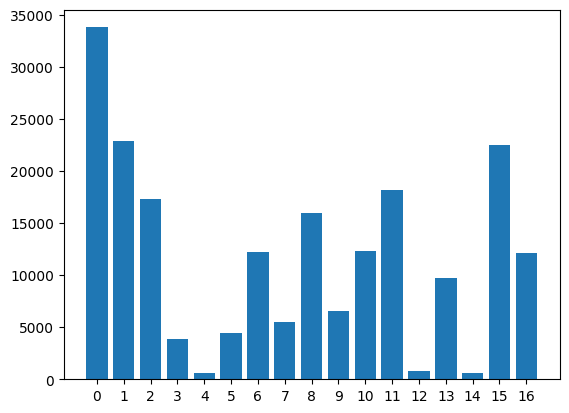

In [21]:
# Create a count plot
tags = [tag for sample in train_dataset['upos'] for tag in sample]
tags_counter = Counter(tags)
plt.xticks(range(number_of_tags))
plt.bar(tags_counter.keys(),tags_counter.values())

In [22]:
tags_counter.most_common()

[(0, 33799),
 (1, 22864),
 (15, 22485),
 (11, 18178),
 (2, 17264),
 (8, 15968),
 (10, 12278),
 (6, 12263),
 (16, 12107),
 (13, 9735),
 (9, 6584),
 (7, 5459),
 (5, 4408),
 (3, 3823),
 (12, 773),
 (14, 640),
 (4, 618)]

In [23]:
sum(tags_counter.values())

199246

testset and trainset vocabulary and tokens count:


In [24]:
vocabs_dict = {}
for tokens_list in test_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('5,630', '24,728')

In [25]:
vocabs_dict = {}
for tokens_list in validation_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('5,495', '24,906')

In [26]:
vocabs_dict = {}
for tokens_list in train_dataset['tokens']:
  for token in tokens_list:
    vocabs_dict[token] = vocabs_dict.get(token,0)+1
f'{len(vocabs_dict.keys()):,}',f'{sum(vocabs_dict.values()):,}'

('19,672', '199,246')

# create helper functions and set constants

In [27]:
max(map(len,train_dataset['tokens'])),max(map(len,test_dataset['tokens']))

(159, 81)

In [28]:
# setting seq_len:
seq_len = 200
pad_tag = number_of_tags # tags starts from zero :)

In [29]:
def create_features_from_tokens_list(tokens_list,tags_list,tokenizer):
  encoded = list()
  padded_tags = list()
  for tokens,tags in tqdm(zip(tokens_list,tags_list)):
    text = ' '.join(tokens)
    encoded_doc = tokenizer.encode(text)
    encoded_doc = tokenizer.pad(encoded_doc,length=seq_len)
    encoded_doc = encoded_doc[:seq_len]
    encoded.append(np.array(encoded_doc))
    padded_tags.append(np.pad(
        tags,
        pad_width=(0,seq_len-len(tags)),
        constant_values=pad_tag,
      )
    )
  return np.array(encoded),np.array(padded_tags)

In [30]:
# define batch size
batch_size = 256

In [31]:
def mask_vowels(tokens_list, mask=""):
  masked_tokens_list = list()
  for token in tokens_list:
    masked_token = re.sub(
      r"[AEIOU]",
      mask,
      token,
      flags=re.IGNORECASE,
    )
    if masked_token:
      masked_tokens_list.append(masked_token)
  return masked_tokens_list

# Build the BiLSTM Model

## The Model Architecture

In [32]:
# model architecture (with some amends)
# https://www.kaggle.com/code/affand20/imdb-with-pytorch

class LitBiLSTMModel(LightningModule):
    def __init__(
        self,
        vocab_size,
        pad_id=1, # the default value from tkseem tokenizers
        pad_tag=pad_tag,
        seq_len=seq_len,
        output_size=18, # one class is added for padding
        hidden_size=256,
        embedding_size=512,
        embedding_dropout=0.5,
        dropout=0.5,
        learning_rate=0.001,
        n_layers=4,
        bidirectional=True,
      ):
        super().__init__()

        self.save_hyperparameters()

        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.dropout_prop = dropout
        self.pad_tag = pad_tag
        self.pad_id = pad_id
        self.max_sequence_length = seq_len
        self.output_size = output_size

        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        self.val_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )
        self.test_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=output_size,
            ignore_index=self.pad_tag,
          )

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(
              embedding_size,
              hidden_size,
              n_layers,
              dropout=dropout,
              batch_first=True,
              bidirectional=bidirectional,
        )

        # dropout layer
        self.dropout = nn.Dropout(dropout)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        outputs = self.embedding(inputs)
        outputs = self.embedding_dropout(outputs) # apply dropout on embedding
        inputs_lengths = torch.sum(inputs!=self.pad_id,axis=-1).cpu()
        packed_outputs = nn.utils.rnn.pack_padded_sequence(
            outputs,
            inputs_lengths,
            batch_first=True,
            enforce_sorted=False,
          )
        if not self.bidirectional:
          # pass forward to lstm
          packed_outputs, _ =  self.lstm(packed_outputs)
          outputs,lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
        else:
          bidirectional_packed_outputs,_ = self.lstm(packed_outputs)
          bidirectional_outputs,lengths = nn.utils.rnn.pad_packed_sequence(
              bidirectional_packed_outputs,
              batch_first=True,
              # padding_value=self.pad_id,
              total_length=self.max_sequence_length,
            )
          outputs = bidirectional_outputs[:, :, : self.hidden_size] + bidirectional_outputs[:, :, self.hidden_size :]
        outputs = self.dropout(outputs)
        outputs = self.fc(outputs)
        # softmax will be done in the loss calculation
        return outputs

    def step(self, inputs, labels):
        assert torch.sum(inputs==self.pad_id)==torch.sum(labels==self.pad_tag),\
             f'pad ids and their target tags does not match: {torch.sum(inputs==self.pad_id):=} != {torch.sum(labels==self.pad_tag):=}'
        outputs = self(inputs)
        outputs = outputs.squeeze()
        outputs = outputs.view(outputs.shape[0]*outputs.shape[1],-1)
        labels = labels.view(-1)
        return outputs,labels

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        train_accuracy = self.train_accuracy(outputs, labels)
        self.log(
            "loss",
            loss,
            prog_bar=True,
            on_step=True,
            on_epoch=False,
        )
        self.log(
            "train_acc",
            train_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        val_accuracy = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log(
            "val_acc",
            val_accuracy,
            on_step=True,
            on_epoch=False,
            prog_bar=True,
            logger=True,
        )
        return {"val_loss": loss}
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs,labels = self.step(inputs, labels)
        loss = F.cross_entropy(
            outputs,
            labels,
            ignore_index=self.pad_tag,
          )
        test_accuracy = self.test_accuracy(outputs,labels)
        metrics = {"test_acc": test_accuracy, "test_loss": loss}
        self.log_dict(metrics, prog_bar=True)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            factor=0.5,
            patience=1,
            verbose=True,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

## util classes/functions

In [33]:
class ConfusionMatrixCallback(Callback):
  def __init__(self,*args,**kwargs):
    super().__init__(*args,**kwargs)
    self.predictions = list()
    self.labels = list()

  def on_test_batch_end(self,trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
    super().on_test_batch_end(
        trainer,
        pl_module,
        outputs,
        batch,
        batch_idx,
        dataloader_idx,
      )
    inputs,labels = batch
    outputs = outputs.view(inputs.shape[0]*inputs.shape[1],-1)
    batch_predictions = torch.argmax(outputs,dim=-1)
    self.predictions.append(batch_predictions)
    labels = labels.view(-1)
    self.labels.append(labels)

  def on_test_end(self, trainer, pl_module) -> None:
     super().on_test_end(trainer, pl_module)
     predictions = torch.cat(self.predictions).cpu()
     labels = torch.cat(self.labels).cpu()
     confusion_matrix_calculator = torchmetrics.ConfusionMatrix(
            task="multiclass",
            num_classes=trainer.model.output_size,
            ignore_index=trainer.model.pad_tag,
     )
     confusion_matrix = confusion_matrix_calculator(predictions,labels)
     # zero out lists for future calculations
     self.predictions = list()
     self.labels = list()
     plt.figure(figsize = (10,7))
     sns.heatmap(confusion_matrix, annot=True,linewidths=0.5,fmt='g',cmap='Blues')

In [34]:
def get_best_checkpoint(text_type,checkpoints_base_path="./POSTagging"):
    checkpoints_path = (
        f"{checkpoints_base_path}/{text_type}/checkpoints"
    )
    for file_name in os.listdir(checkpoints_path):
        if file_name.startswith("epoch"):
            return f"{checkpoints_path}/{file_name}"

In [35]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    text_type,
    max_epochs=50,
  ):
  checkpoints_path = Path(f"./POSTagging/{text_type}")
  shutil.rmtree(checkpoints_path, ignore_errors=True)
  checkpoint_callback = ModelCheckpoint(
      mode="min",
      save_top_k=1,
      verbose=False,
      save_last=True,
      monitor="val_loss",
      save_weights_only=False,
      auto_insert_metric_name=True,
      save_on_train_epoch_end=False,
      dirpath=f"{checkpoints_path}/checkpoints",
      filename="{epoch}-{val_loss:.3f}-{step}",
  )
  callbacks = list()
  callbacks.append(checkpoint_callback)
  confusion_matrix_callback = ConfusionMatrixCallback()
  callbacks.append(confusion_matrix_callback)
  early_stopping_callback = EarlyStopping(
      monitor="val_loss",
      # min_delta=0.025,
      min_delta=0,
      patience=10,
      check_finite=True,
  )
  callbacks.append(early_stopping_callback)
  lr_monitor = LearningRateMonitor(
      logging_interval="step",
      log_momentum=True,
  )
  callbacks.append(lr_monitor)
  devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  trainer = Trainer(
      deterministic=True,
      callbacks=callbacks,
      gradient_clip_val=5,
      fast_dev_run=False,
      max_epochs=max_epochs,
      val_check_interval=0.5,
      accelerator="auto",
      # log_every_n_steps=max(len(train_dataloader) // 25, 1),
      log_every_n_steps=max(len(train_dataloader) // 25, 1),
  )
  trainer.validate(
      model=model,
      dataloaders=val_dataloader,
  )
  trainer.fit(
      model,
      train_dataloader,
      val_dataloader,
  )
  return trainer

# Normal English

## Prepare the tokenizer

In [36]:
tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [37]:
tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['tokens']))

Training WordTokenizer ...


In [38]:
tokenizer.vocab_size

19674

In [39]:
# test the tokenizer
tokenizer.tokenize('the hello world , fractionally')

['the', 'hello', 'world', ',', '<UNK>']

## tokenize and split

In [40]:
encoded_trainset,trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['tokens'],
    tags_list=train_dataset['upos'],
    tokenizer=tokenizer,
  )
encoded_valset,valy = create_features_from_tokens_list(
    tokens_list=validation_dataset['tokens'],
    tags_list=validation_dataset['upos'],
    tokenizer=tokenizer,
  )
encoded_testset,testy = create_features_from_tokens_list(
    tokens_list=test_dataset['tokens'],
    tags_list=test_dataset['upos'],
    tokenizer=tokenizer,
  )
encoded_trainset.shape,trainy.shape,encoded_valset.shape,valy.shape,encoded_testset.shape,testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((11734, 200),
 (11734, 200),
 (1914, 200),
 (1914, 200),
 (1971, 200),
 (1971, 200))

In [41]:
# create tensor datasets
trainset = TensorDataset(torch.from_numpy(encoded_trainset), torch.from_numpy(trainy))
validset = TensorDataset(torch.from_numpy(encoded_valset), torch.from_numpy(valy))
testset = TensorDataset(torch.from_numpy(encoded_testset), torch.from_numpy(testy))

In [42]:
# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size,num_workers=4)
valloader = DataLoader(validset, shuffle=False, batch_size=batch_size,num_workers=4)
testloader = DataLoader(testset, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [43]:
model = LitBiLSTMModel(vocab_size=tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(19674, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

In [44]:
trainer = train_model(
    model,
    train_dataloader=trainloader,
    val_dataloader=valloader,
    text_type='all-characters',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.9010567665100098     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 10.1 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 4.6 K 
---------------------------------------------------------
16.4 M    Trainable params
0         Non-trainable params
16.4 M    Total params
65.542    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9143879413604736     │
│         test_loss         │    0.2942999303340912     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9143879413604736, 'test_loss': 0.2942999303340912}]

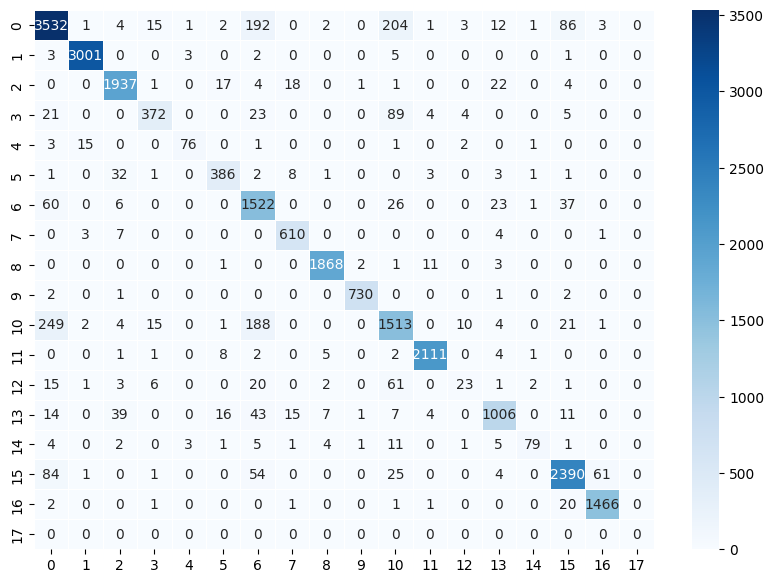

In [45]:
#9119 test on the last model
trainer.test(model,testloader)

In [46]:
# test on teh best model according to val accuracy
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='all-characters',),
    vocab_size=tokenizer.vocab_size
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(19674, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9128684997558594     │
│         test_loss         │    0.29126930236816406    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9128684997558594, 'test_loss': 0.29126930236816406}]

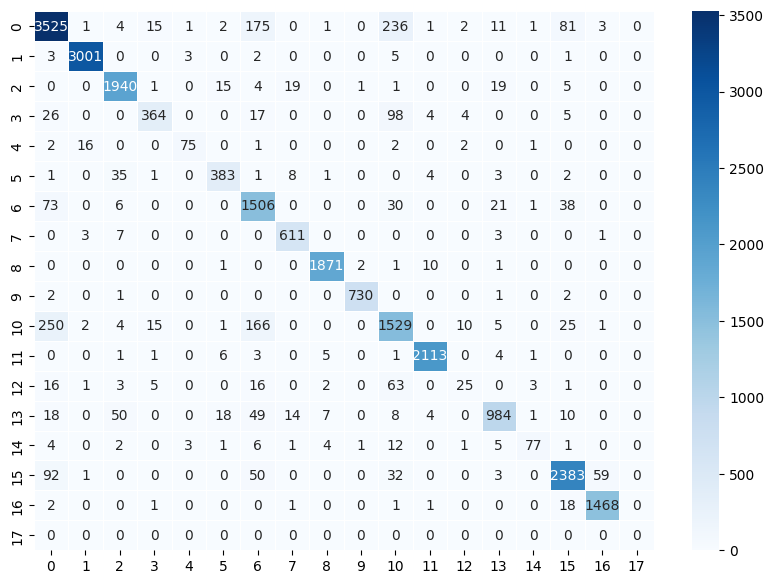

In [47]:
trainer.test(model,testloader)

# Consonants only

## prepare the dataset

In [48]:
# go over tokens, if a token contains only vowels, drop its upos tag
train_dataset['constants_upos'] = train_dataset.progress_apply(lambda row: [tag for tag,token in zip(row['upos'],row['tokens']) if not set(token).issubset('AaEeIiOoUu')],axis=1)
train_dataset

  0%|          | 0/11734 [00:00<?, ?it/s]

idx  \
0      weblog-juancole.com_juancole_20051126063000_EN...   
1      weblog-juancole.com_juancole_20051126063000_EN...   
2      weblog-juancole.com_juancole_20051126063000_EN...   
3      weblog-juancole.com_juancole_20051126063000_EN...   
4      weblog-juancole.com_juancole_20051126063000_EN...   
...                                                  ...   
12538                                reviews-319816-0025   
12539                                reviews-319816-0026   
12540                                reviews-319816-0027   
12541                                reviews-319816-0028   
12542                                reviews-319816-0029   

                                                    text  \
0      Al-Zaman : American forces killed Shaikh Abdul...   
1      [This killing of a respected cleric will be ca...   
2      DPA: Iraqi authorities announced that they had...   
3      Two of them were being run by 2 officials of t...   
4      The MoI in Iraq is equivalent to the US FBI, s...   
...                                                  ...   
12538  Of course, they couldn't call him either to as...   
12539  On Monday I called and again it was a big to-d...   
12540  Supposedly they will be holding it for me this...   
12541  The employees at this Sear's are completely ap...   
12542  I will never return there again (and now have ...   

                                                  tokens  \
0      [Al, -, Zaman, :, American, forces, killed, Sh...   
1      [[, This, killing, of, a, respected, cleric, w...   
2      [DPA, :, Iraqi, authorities, announced, that, ...   
3      [Two, of, them, were, being, run, by, 2, offic...   
4      [The, MoI, in, Iraq, is, equivalent, to, the, ...   
...                                                  ...   
12538  [Of, course, ,, they, could, n't, call, him, e...   
12539  [On, Monday, I, called, and, again, it, was, a...   
12540  [Supposedly, they, will, be, holding, it, for,...   
12541  [The, employees, at, this, Sear's, are, comple...   
12542  [I, will, never, return, there, again, (, and,...   

                                                  lemmas  \
0      [Al, -, Zaman, :, american, force, kill, Shaik...   
1      [[, this, killing, of, a, respected, cleric, w...   
2      [DPA, :, iraqi, authority, announce, that, the...   
3      [two, of, they, be, be, run, by, 2, official, ...   
4      [the, MoI, in, Iraq, be, equivalent, to, the, ...   
...                                                  ...   
12538  [of, course, ,, they, _, could, not, call, he,...   
12539  [on, Monday, I, call, and, again, it, be, a, b...   
12540  [supposedly, they, will, be, hold, it, for, I,...   
12541  [the, employee, at, this, Sears, be, completel...   
12542  [I, will, never, return, there, again, (, and,...   

                                                    upos  \
0      [10, 1, 10, 1, 6, 0, 15, 10, 10, 10, 1, 10, 1,...   
1      [1, 8, 0, 2, 8, 6, 0, 16, 16, 15, 11, 0, 2, 0,...   
2      [10, 1, 6, 0, 15, 5, 11, 16, 15, 2, 3, 6, 0, 1...   
3      [3, 2, 11, 16, 16, 15, 2, 3, 0, 2, 8, 10, 2, 8...   
4      [8, 10, 2, 10, 16, 6, 2, 8, 10, 10, 1, 13, 11,...   
...                                                  ...   
12538  [13, 13, 1, 11, 16, 7, 15, 11, 13, 7, 15, 2, 1...   
12539  [2, 10, 11, 15, 9, 13, 11, 16, 8, 6, 0, 1, 0, ...   
12540  [13, 11, 16, 16, 15, 11, 2, 11, 8, 0, 1, 9, 11...   
12541  [8, 0, 2, 8, 10, 16, 13, 6, 9, 11, 16, 7, 15, ...   
12542  [11, 16, 13, 15, 13, 13, 1, 9, 13, 15, 8, 6, 0...   

                                                    xpos  \
0      [NNP, HYPH, NNP, :, JJ, NNS, VBD, NNP, NNP, NN...   
1      [-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...   
2      [NNP, :, JJ, NNS, VBD, IN, PRP, VBD, VBN, RP, ...   
3      [CD, IN, PRP, VBD, VBG, VBN, IN, CD, NNS, IN, ...   
4      [DT, NNP, IN, NNP, VBZ, JJ, IN, DT, NNP, NNP, ...   
...                                                  ...   
12538  [RB, RB, ,, PRP, None

In [49]:
train_dataset['constants_tokens'] = list(train_dataset['tokens'].progress_apply(mask_vowels))
train_dataset

  0%|          | 0/11734 [00:00<?, ?it/s]

idx  \
0      weblog-juancole.com_juancole_20051126063000_EN...   
1      weblog-juancole.com_juancole_20051126063000_EN...   
2      weblog-juancole.com_juancole_20051126063000_EN...   
3      weblog-juancole.com_juancole_20051126063000_EN...   
4      weblog-juancole.com_juancole_20051126063000_EN...   
...                                                  ...   
12538                                reviews-319816-0025   
12539                                reviews-319816-0026   
12540                                reviews-319816-0027   
12541                                reviews-319816-0028   
12542                                reviews-319816-0029   

                                                    text  \
0      Al-Zaman : American forces killed Shaikh Abdul...   
1      [This killing of a respected cleric will be ca...   
2      DPA: Iraqi authorities announced that they had...   
3      Two of them were being run by 2 officials of t...   
4      The MoI in Iraq is equivalent to the US FBI, s...   
...                                                  ...   
12538  Of course, they couldn't call him either to as...   
12539  On Monday I called and again it was a big to-d...   
12540  Supposedly they will be holding it for me this...   
12541  The employees at this Sear's are completely ap...   
12542  I will never return there again (and now have ...   

                                                  tokens  \
0      [Al, -, Zaman, :, American, forces, killed, Sh...   
1      [[, This, killing, of, a, respected, cleric, w...   
2      [DPA, :, Iraqi, authorities, announced, that, ...   
3      [Two, of, them, were, being, run, by, 2, offic...   
4      [The, MoI, in, Iraq, is, equivalent, to, the, ...   
...                                                  ...   
12538  [Of, course, ,, they, could, n't, call, him, e...   
12539  [On, Monday, I, called, and, again, it, was, a...   
12540  [Supposedly, they, will, be, holding, it, for,...   
12541  [The, employees, at, this, Sear's, are, comple...   
12542  [I, will, never, return, there, again, (, and,...   

                                                  lemmas  \
0      [Al, -, Zaman, :, american, force, kill, Shaik...   
1      [[, this, killing, of, a, respected, cleric, w...   
2      [DPA, :, iraqi, authority, announce, that, the...   
3      [two, of, they, be, be, run, by, 2, official, ...   
4      [the, MoI, in, Iraq, be, equivalent, to, the, ...   
...                                                  ...   
12538  [of, course, ,, they, _, could, not, call, he,...   
12539  [on, Monday, I, call, and, again, it, be, a, b...   
12540  [supposedly, they, will, be, hold, it, for, I,...   
12541  [the, employee, at, this, Sears, be, completel...   
12542  [I, will, never, return, there, again, (, and,...   

                                                    upos  \
0      [10, 1, 10, 1, 6, 0, 15, 10, 10, 10, 1, 10, 1,...   
1      [1, 8, 0, 2, 8, 6, 0, 16, 16, 15, 11, 0, 2, 0,...   
2      [10, 1, 6, 0, 15, 5, 11, 16, 15, 2, 3, 6, 0, 1...   
3      [3, 2, 11, 16, 16, 15, 2, 3, 0, 2, 8, 10, 2, 8...   
4      [8, 10, 2, 10, 16, 6, 2, 8, 10, 10, 1, 13, 11,...   
...                                                  ...   
12538  [13, 13, 1, 11, 16, 7, 15, 11, 13, 7, 15, 2, 1...   
12539  [2, 10, 11, 15, 9, 13, 11, 16, 8, 6, 0, 1, 0, ...   
12540  [13, 11, 16, 16, 15, 11, 2, 11, 8, 0, 1, 9, 11...   
12541  [8, 0, 2, 8, 10, 16, 13, 6, 9, 11, 16, 7, 15, ...   
12542  [11, 16, 13, 15, 13, 13, 1, 9, 13, 15, 8, 6, 0...   

                                                    xpos  \
0      [NNP, HYPH, NNP, :, JJ, NNS, VBD, NNP, NNP, NN...   
1      [-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...   
2      [NNP, :, JJ, NNS, VBD, IN, PRP, VBD, VBN, RP, ...   
3      [CD, IN, PRP, VBD, VBG, VBN, IN, CD, NNS, IN, ...   
4      [DT, NNP, IN, NNP, VBZ, JJ, IN, DT, NNP, NNP, ...   
...                                                  ...   
12538  [RB, RB, ,, PRP, None

In [50]:
# let us find out the tokens that are all vowels to analyze the severity of their removal
vowel_words = list()
vowel_tags = list()
for index,row in tqdm(train_dataset.iterrows()):
  for index,token in enumerate(row['tokens']):
    if set(token).issubset('AaEeIiOoUu'):
      vowel_words.append(token)
      vowel_tags.append(row['upos'][index])
set(vowel_words),len(vowel_words),len(set(vowel_words)),Counter(vowel_words).most_common(),\
set(vowel_tags),len(vowel_tags),len(set(vowel_tags)),Counter(vowel_tags).most_common()

0it [00:00, ?it/s]

({'A',
  'AA',
  'AAA',
  'E',
  'EEI',
  'EI',
  'EU',
  'I',
  'IAEA',
  'II',
  'III',
  'O',
  'U',
  'a',
  'aa',
  'ai',
  'e',
  'i',
  'ie',
  'ii',
  'iii',
  'o',
  'u'},
 7085,
 23,
 [('a', 3542),
  ('I', 3045),
  ('i', 256),
  ('A', 170),
  ('II', 14),
  ('u', 8),
  ('AA', 6),
  ('e', 5),
  ('EEI', 5),
  ('o', 5),
  ('ai', 4),
  ('U', 4),
  ('IAEA', 3),
  ('III', 3),
  ('EU', 3),
  ('EI', 2),
  ('ie', 2),
  ('E', 2),
  ('O', 2),
  ('ii', 1),
  ('iii', 1),
  ('AAA', 1),
  ('aa', 1)],
 {0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 16},
 7085,
 13,
 [(8, 3672),
  (11, 3305),
  (10, 29),
  (0, 24),
  (12, 18),
  (3, 10),
  (2, 9),
  (13, 6),
  (16, 5),
  (4, 4),
  (14, 1),
  (9, 1),
  (7, 1)])

In [51]:
# assert that constants upos and constants tokens have the same length always
for index,row in train_dataset.iterrows():
  if len(row['constants_upos']) != len(row['constants_tokens']):
    print(row['constants_upos'],'and',row['contants_tokens'],'does not have the same length!')
    break
else:
  print('all contants upos and constant tokens rows have the same length')

all contants upos and constant tokens rows have the same length


In [52]:
train_dataset['constants_tokens'][0],train_dataset['tokens'][0]

(['l',
  '-',
  'Zmn',
  ':',
  'mrcn',
  'frcs',
  'klld',
  'Shkh',
  'bdllh',
  'l',
  '-',
  'n',
  ',',
  'th',
  'prchr',
  't',
  'th',
  'msq',
  'n',
  'th',
  'twn',
  'f',
  'Qm',
  ',',
  'nr',
  'th',
  'Syrn',
  'brdr',
  '.'],
 array(['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh',
        'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the',
        'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the',
        'Syrian', 'border', '.'], dtype=object))

apply similar processing for validation set

In [53]:
validation_dataset['constants_upos'] = validation_dataset.progress_apply(lambda row: [tag for tag,token in zip(row['upos'],row['tokens']) if not set(token).issubset('AaEeIiOoUu')],axis=1)
validation_dataset

  0%|          | 0/1914 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_nominations_20041117172713...   
1     weblog-blogspot.com_nominations_20041117172713...   
2     weblog-blogspot.com_nominations_20041117172713...   
3     weblog-blogspot.com_nominations_20041117172713...   
4     weblog-blogspot.com_nominations_20041117172713...   
...                                                 ...   
1997                                reviews-202709-0003   
1998                                reviews-140302-0001   
1999                                reviews-140302-0002   
2000                                reviews-140302-0003   
2001                                reviews-140302-0004   

                                                   text  \
0                        From the AP comes this story :   
1     President Bush on Tuesday nominated two indivi...   
2     Bush nominated Jennifer M. Anderson for a 15-y...   
3                                                   ***   
4     Bush also nominated A. Noel Anketell Kramer fo...   
...                                                 ...   
1997  I recommend you to everyone in Calgary, as she...   
1998                                  5 star detail job   
1999  I took my Mustang here and it looked amazing a...   
2000  The paint and wheels looked like glass and the...   
2001  Also, they have great customer service and a v...   

                                                 tokens  \
0                [From, the, AP, comes, this, story, :]   
1     [President, Bush, on, Tuesday, nominated, two,...   
2     [Bush, nominated, Jennifer, M., Anderson, for,...   
3                                                 [***]   
4     [Bush, also, nominated, A., Noel, Anketell, Kr...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, took, my, Mustang, here, and, it, looked, ...   
2000  [The, paint, and, wheels, looked, like, glass,...   
2001  [Also, ,, they, have, great, customer, service...   

                                                 lemmas  \
0                 [from, the, AP, come, this, story, :]   
1     [President, Bush, on, Tuesday, nominate, two, ...   
2     [Bush, nominate, Jennifer, M., Anderson, for, ...   
3                                                 [***]   
4     [Bush, also, nominate, A., Noel, Anketell, Kra...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, take, my, Mustang, here, and, it, look, am...   
2000  [the, paint, and, wheel, look, like, glass, an...   
2001  [also, ,, they, have, great, customer, service...   

                                                   upos  \
0                               [2, 8, 10, 15, 8, 0, 1]   
1     [10, 10, 2, 10, 15, 3, 0, 7, 15, 15, 0, 2, 6, ...   
2     [10, 15, 10, 10, 10, 2, 8, 3, 1, 0, 0, 2, 6, 0...   
3                                                   [1]   
4     [10, 13, 15, 10, 10, 10, 10, 2, 8, 3, 1, 0, 0,...   
...                                                 ...   
1997  [11, 15, 11, 2, 11, 2, 10, 1, 5, 11, 16, 8, 0,...   
1998                                       [3, 0, 0, 0]   
1999  [11, 15, 11, 10, 13, 9, 11, 15, 6, 5, 11, 16, ...   
2000          [8, 0, 9, 0, 15, 2, 0, 9, 8, 0, 15, 6, 1]   
2001           [13, 1, 11, 15, 6, 0, 0, 9, 8, 13, 6, 0]   

                                                   xpos  \
0                         [IN, DT, NNP, VBZ, DT, NN, :]   
1     [NNP, NNP, IN, NNP, VBD, CD, NNS, TO, VB, VBG,...   
2     [NNP, VBD, NNP, NNP, NNP, IN, DT, CD, HYPH, NN...   
3                                                 [NFP]   
4     [NNP, RB, VBD, NNP, NNP, NNP, NNP, IN, DT, CD,...   
...                                                 ...   
1997  [PRP, VBP, PRP, IN, NN, IN, NNP, ,, IN, PRP, V...   
1998                               

In [54]:
validation_dataset['constants_tokens'] = list(validation_dataset['tokens'].progress_apply(mask_vowels))
validation_dataset

  0%|          | 0/1914 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_nominations_20041117172713...   
1     weblog-blogspot.com_nominations_20041117172713...   
2     weblog-blogspot.com_nominations_20041117172713...   
3     weblog-blogspot.com_nominations_20041117172713...   
4     weblog-blogspot.com_nominations_20041117172713...   
...                                                 ...   
1997                                reviews-202709-0003   
1998                                reviews-140302-0001   
1999                                reviews-140302-0002   
2000                                reviews-140302-0003   
2001                                reviews-140302-0004   

                                                   text  \
0                        From the AP comes this story :   
1     President Bush on Tuesday nominated two indivi...   
2     Bush nominated Jennifer M. Anderson for a 15-y...   
3                                                   ***   
4     Bush also nominated A. Noel Anketell Kramer fo...   
...                                                 ...   
1997  I recommend you to everyone in Calgary, as she...   
1998                                  5 star detail job   
1999  I took my Mustang here and it looked amazing a...   
2000  The paint and wheels looked like glass and the...   
2001  Also, they have great customer service and a v...   

                                                 tokens  \
0                [From, the, AP, comes, this, story, :]   
1     [President, Bush, on, Tuesday, nominated, two,...   
2     [Bush, nominated, Jennifer, M., Anderson, for,...   
3                                                 [***]   
4     [Bush, also, nominated, A., Noel, Anketell, Kr...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, took, my, Mustang, here, and, it, looked, ...   
2000  [The, paint, and, wheels, looked, like, glass,...   
2001  [Also, ,, they, have, great, customer, service...   

                                                 lemmas  \
0                 [from, the, AP, come, this, story, :]   
1     [President, Bush, on, Tuesday, nominate, two, ...   
2     [Bush, nominate, Jennifer, M., Anderson, for, ...   
3                                                 [***]   
4     [Bush, also, nominate, A., Noel, Anketell, Kra...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, take, my, Mustang, here, and, it, look, am...   
2000  [the, paint, and, wheel, look, like, glass, an...   
2001  [also, ,, they, have, great, customer, service...   

                                                   upos  \
0                               [2, 8, 10, 15, 8, 0, 1]   
1     [10, 10, 2, 10, 15, 3, 0, 7, 15, 15, 0, 2, 6, ...   
2     [10, 15, 10, 10, 10, 2, 8, 3, 1, 0, 0, 2, 6, 0...   
3                                                   [1]   
4     [10, 13, 15, 10, 10, 10, 10, 2, 8, 3, 1, 0, 0,...   
...                                                 ...   
1997  [11, 15, 11, 2, 11, 2, 10, 1, 5, 11, 16, 8, 0,...   
1998                                       [3, 0, 0, 0]   
1999  [11, 15, 11, 10, 13, 9, 11, 15, 6, 5, 11, 16, ...   
2000          [8, 0, 9, 0, 15, 2, 0, 9, 8, 0, 15, 6, 1]   
2001           [13, 1, 11, 15, 6, 0, 0, 9, 8, 13, 6, 0]   

                                                   xpos  \
0                         [IN, DT, NNP, VBZ, DT, NN, :]   
1     [NNP, NNP, IN, NNP, VBD, CD, NNS, TO, VB, VBG,...   
2     [NNP, VBD, NNP, NNP, NNP, IN, DT, CD, HYPH, NN...   
3                                                 [NFP]   
4     [NNP, RB, VBD, NNP, NNP, NNP, NNP, IN, DT, CD,...   
...                                                 ...   
1997  [PRP, VBP, PRP, IN, NN, IN, NNP, ,, IN, PRP, V...   
1998                               

In [55]:
# assert that constants upos and constants tokens have the same length always
for index,row in validation_dataset.iterrows():
  if len(row['constants_upos']) != len(row['constants_tokens']):
    print(row['constants_upos'],'and',row['contants_tokens'],'does not have the same length!')
    break
else:
  print('all contants upos and constant tokens rows have the same length')

all contants upos and constant tokens rows have the same length


apply similar processing for test set

In [56]:
# go over tokens, if a token contains only vowels, drop its upos tag
test_dataset['constants_upos'] = test_dataset.progress_apply(lambda row: [tag for tag,token in zip(row['upos'],row['tokens']) if not set(token).issubset('AaEeIiOoUu')],axis=1)
test_dataset

  0%|          | 0/1971 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_zentelligence_200404230002...   
1     weblog-blogspot.com_zentelligence_200404230002...   
2     weblog-blogspot.com_zentelligence_200404230002...   
3     weblog-blogspot.com_marketview_20050511222700_...   
4     weblog-blogspot.com_marketview_20050511222700_...   
...                                                 ...   
2072                                reviews-216281-0007   
2073                                reviews-216281-0008   
2074                                reviews-211933-0001   
2075                                reviews-211933-0002   
2076                                reviews-211933-0003   

                                                   text  \
0                 What if Google Morphed Into GoogleOS?   
1     What if Google expanded on its search-engine (...   
2             [via Microsoft Watch from Mary Jo Foley ]   
3     (And, by the way, is anybody else just a littl...   
4     This BuzzMachine post argues that Google's rus...   
...                                                 ...   
2072                                        thanks Rich   
2073                                            Seth K.   
2074  Deep tissue massage helps with pain in neck an...   
2075  Seth provides deep tissue massage which has si...   
2076  He listens and is excellent in diagnosing, add...   

                                                 tokens  \
0        [What, if, Google, Morphed, Into, GoogleOS, ?]   
1     [What, if, Google, expanded, on, its, search, ...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, And, ,, by, the, way, ,, is, anybody, else...   
4     [This, BuzzMachine, post, argues, that, Google...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [Deep, tissue, massage, helps, with, pain, in,...   
2075  [Seth, provides, deep, tissue, massage, which,...   
2076  [He, listens, and, is, excellent, in, diagnosi...   

                                                 lemmas  \
0          [what, if, Google, morph, into, GoogleOS, ?]   
1     [what, if, Google, expand, on, its, search, -,...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, and, ,, by, the, way, ,, be, anybody, else...   
4     [this, BuzzMachine, post, argue, that, _, Goog...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [deep, tissue, massage, help, with, pain, in, ...   
2075  [Seth, provide, deep, tissue, massage, which, ...   
2076  [he, listen, and, be, excellent, in, diagnose,...   

                                                   upos  \
0                             [11, 5, 10, 15, 2, 10, 1]   
1     [11, 5, 10, 15, 2, 11, 0, 1, 0, 1, 9, 13, 0, 1...   
2                      [1, 2, 10, 10, 2, 10, 10, 10, 1]   
3     [1, 9, 1, 2, 8, 0, 1, 16, 11, 6, 13, 8, 6, 0, ...   
4     [8, 10, 0, 15, 5, 10, 7, 0, 2, 0, 16, 15, 1, 1...   
...                                                 ...   
2072                                            [0, 10]   
2073                                        [10, 10, 1]   
2074                    [6, 0, 0, 15, 2, 0, 2, 0, 9, 0]   
2075  [10, 15, 6, 0, 0, 11, 16, 13, 15, 8, 0, 2, 11,...   
2076  [11, 15, 9, 16, 6, 5, 15, 1, 15, 9, 15, 8, 6, ...   

                                                   xpos  \
0                        [WP, IN, NNP, VBD, IN, NNP, .]   
1     [WP, IN, NNP, VBD, IN, PRP$, NN, HYPH, NN, -LR...   
2       [-LRB-, IN, NNP, NNP, IN, NNP, NNP, NNP, -RRB-]   
3     [-LRB-, CC, ,, IN, DT, NN, ,, VBZ, NN, JJ, RB,...   
4     [DT, NNP, NN, VBZ, IN, None, NNP, POS, NN, IN,...   
...                                                 ...   
2072                                          [NN, NNP]   
2073                               

In [57]:
test_dataset['constants_tokens'] = list(test_dataset['tokens'].progress_apply(mask_vowels))
test_dataset

  0%|          | 0/1971 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_zentelligence_200404230002...   
1     weblog-blogspot.com_zentelligence_200404230002...   
2     weblog-blogspot.com_zentelligence_200404230002...   
3     weblog-blogspot.com_marketview_20050511222700_...   
4     weblog-blogspot.com_marketview_20050511222700_...   
...                                                 ...   
2072                                reviews-216281-0007   
2073                                reviews-216281-0008   
2074                                reviews-211933-0001   
2075                                reviews-211933-0002   
2076                                reviews-211933-0003   

                                                   text  \
0                 What if Google Morphed Into GoogleOS?   
1     What if Google expanded on its search-engine (...   
2             [via Microsoft Watch from Mary Jo Foley ]   
3     (And, by the way, is anybody else just a littl...   
4     This BuzzMachine post argues that Google's rus...   
...                                                 ...   
2072                                        thanks Rich   
2073                                            Seth K.   
2074  Deep tissue massage helps with pain in neck an...   
2075  Seth provides deep tissue massage which has si...   
2076  He listens and is excellent in diagnosing, add...   

                                                 tokens  \
0        [What, if, Google, Morphed, Into, GoogleOS, ?]   
1     [What, if, Google, expanded, on, its, search, ...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, And, ,, by, the, way, ,, is, anybody, else...   
4     [This, BuzzMachine, post, argues, that, Google...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [Deep, tissue, massage, helps, with, pain, in,...   
2075  [Seth, provides, deep, tissue, massage, which,...   
2076  [He, listens, and, is, excellent, in, diagnosi...   

                                                 lemmas  \
0          [what, if, Google, morph, into, GoogleOS, ?]   
1     [what, if, Google, expand, on, its, search, -,...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, and, ,, by, the, way, ,, be, anybody, else...   
4     [this, BuzzMachine, post, argue, that, _, Goog...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [deep, tissue, massage, help, with, pain, in, ...   
2075  [Seth, provide, deep, tissue, massage, which, ...   
2076  [he, listen, and, be, excellent, in, diagnose,...   

                                                   upos  \
0                             [11, 5, 10, 15, 2, 10, 1]   
1     [11, 5, 10, 15, 2, 11, 0, 1, 0, 1, 9, 13, 0, 1...   
2                      [1, 2, 10, 10, 2, 10, 10, 10, 1]   
3     [1, 9, 1, 2, 8, 0, 1, 16, 11, 6, 13, 8, 6, 0, ...   
4     [8, 10, 0, 15, 5, 10, 7, 0, 2, 0, 16, 15, 1, 1...   
...                                                 ...   
2072                                            [0, 10]   
2073                                        [10, 10, 1]   
2074                    [6, 0, 0, 15, 2, 0, 2, 0, 9, 0]   
2075  [10, 15, 6, 0, 0, 11, 16, 13, 15, 8, 0, 2, 11,...   
2076  [11, 15, 9, 16, 6, 5, 15, 1, 15, 9, 15, 8, 6, ...   

                                                   xpos  \
0                        [WP, IN, NNP, VBD, IN, NNP, .]   
1     [WP, IN, NNP, VBD, IN, PRP$, NN, HYPH, NN, -LR...   
2       [-LRB-, IN, NNP, NNP, IN, NNP, NNP, NNP, -RRB-]   
3     [-LRB-, CC, ,, IN, DT, NN, ,, VBZ, NN, JJ, RB,...   
4     [DT, NNP, NN, VBZ, IN, None, NNP, POS, NN, IN,...   
...                                                 ...   
2072                                          [NN, NNP]   
2073                               

In [58]:
# assert that constants upos and constants tokens have the same length always
for index,row in test_dataset.iterrows():
  if len(row['constants_upos']) != len(row['constants_tokens']):
    print(row['constants_upos'],'and',row['contants_tokens'],'does not have the same length!')
    break
else:
  print('all contants upos and constant tokens rows have the same length')

all contants upos and constant tokens rows have the same length


In [59]:
test_dataset['constants_tokens'][0],test_dataset['tokens'][0]

(['Wht', 'f', 'Ggl', 'Mrphd', 'nt', 'GglS', '?'],
 array(['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?'],
       dtype=object))

## create the tokenizer

In [60]:
consonants_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [61]:
consonants_tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['constants_tokens']))

Training WordTokenizer ...


In [62]:
consonants_tokenizer.vocab_size

15605

In [63]:
# test the tokenizer
consonants_tokenizer.tokenize('th hll wrld , frctnlly')

['th', 'hll', 'wrld', ',', '<UNK>']

## tokenize and split

In [64]:
consonants_encoded_trainset,consonants_trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['constants_tokens'],
    tags_list=train_dataset['constants_upos'],
    tokenizer=consonants_tokenizer,
  )
consonants_encoded_valset,consonants_valy = create_features_from_tokens_list(
    tokens_list=validation_dataset['constants_tokens'],
    tags_list=validation_dataset['constants_upos'],
    tokenizer=consonants_tokenizer,
  )
consonants_encoded_testset,consonants_testy = create_features_from_tokens_list(
    tokens_list=test_dataset['constants_tokens'],
    tags_list=test_dataset['constants_upos'],
    tokenizer=consonants_tokenizer,
  )
consonants_encoded_trainset.shape,consonants_trainy.shape,consonants_encoded_valset.shape,consonants_valy.shape,consonants_encoded_testset.shape,consonants_testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((11734, 200),
 (11734, 200),
 (1914, 200),
 (1914, 200),
 (1971, 200),
 (1971, 200))

In [65]:
# create tensor datasets
consonants_trainset = TensorDataset(torch.from_numpy(consonants_encoded_trainset), torch.from_numpy(consonants_trainy))
consonants_validset = TensorDataset(torch.from_numpy(consonants_encoded_valset), torch.from_numpy(consonants_valy))
consonants_testset = TensorDataset(torch.from_numpy(consonants_encoded_testset), torch.from_numpy(consonants_testy))

In [66]:
# create dataloaders
consonants_trainloader = DataLoader(consonants_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
consonants_valloader = DataLoader(consonants_validset, shuffle=False, batch_size=batch_size,num_workers=4)
consonants_testloader = DataLoader(consonants_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [67]:
model = LitBiLSTMModel(vocab_size=consonants_tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(15605, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

In [68]:
trainer = train_model(
    model,
    train_dataloader=consonants_trainloader,
    val_dataloader=consonants_valloader,
    text_type='consonants',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.8756864070892334     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 8.0 M 
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 4.6 K 
---------------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.209    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8726043701171875     │
│         test_loss         │    0.46314865350723267    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8726043701171875, 'test_loss': 0.46314865350723267}]

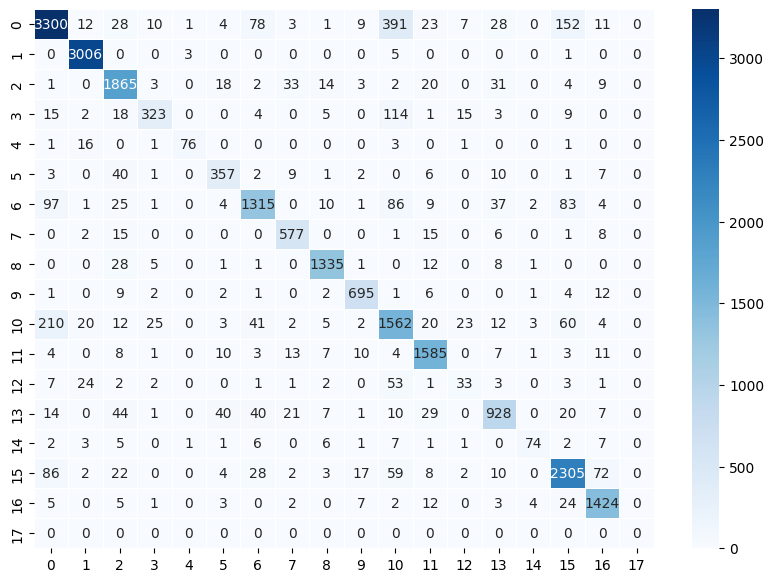

In [69]:
# test on the last model
trainer.test(model,consonants_testloader)

In [70]:
# test on the best model according to the val loss
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='consonants',),
    vocab_size=consonants_tokenizer.vocab_size,
  )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(15605, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8713374137878418     │
│         test_loss         │    0.44617074728012085    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8713374137878418, 'test_loss': 0.44617074728012085}]

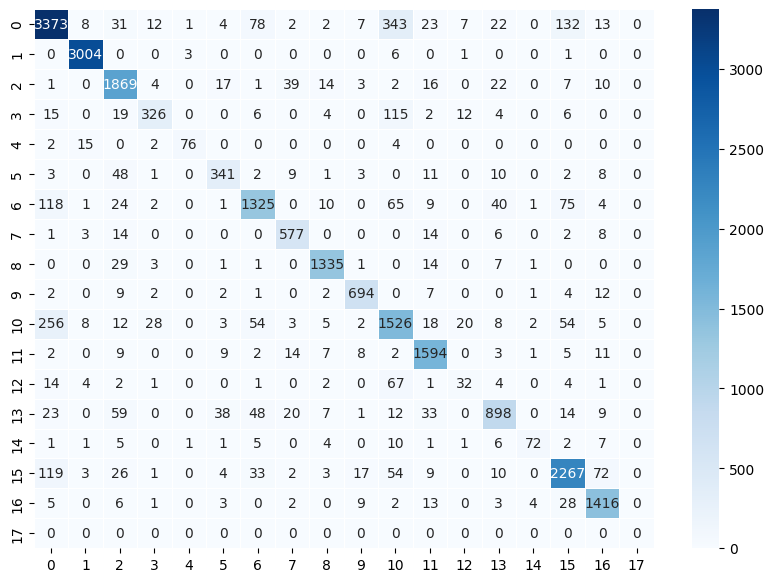

In [71]:
trainer.test(model,consonants_testloader)

# Masked Consonants

## prepare the dataset

In [72]:
train_dataset['masked_constants_tokens'] = list(train_dataset['tokens'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a")))
train_dataset

  0%|          | 0/11734 [00:00<?, ?it/s]

idx  \
0      weblog-juancole.com_juancole_20051126063000_EN...   
1      weblog-juancole.com_juancole_20051126063000_EN...   
2      weblog-juancole.com_juancole_20051126063000_EN...   
3      weblog-juancole.com_juancole_20051126063000_EN...   
4      weblog-juancole.com_juancole_20051126063000_EN...   
...                                                  ...   
12538                                reviews-319816-0025   
12539                                reviews-319816-0026   
12540                                reviews-319816-0027   
12541                                reviews-319816-0028   
12542                                reviews-319816-0029   

                                                    text  \
0      Al-Zaman : American forces killed Shaikh Abdul...   
1      [This killing of a respected cleric will be ca...   
2      DPA: Iraqi authorities announced that they had...   
3      Two of them were being run by 2 officials of t...   
4      The MoI in Iraq is equivalent to the US FBI, s...   
...                                                  ...   
12538  Of course, they couldn't call him either to as...   
12539  On Monday I called and again it was a big to-d...   
12540  Supposedly they will be holding it for me this...   
12541  The employees at this Sear's are completely ap...   
12542  I will never return there again (and now have ...   

                                                  tokens  \
0      [Al, -, Zaman, :, American, forces, killed, Sh...   
1      [[, This, killing, of, a, respected, cleric, w...   
2      [DPA, :, Iraqi, authorities, announced, that, ...   
3      [Two, of, them, were, being, run, by, 2, offic...   
4      [The, MoI, in, Iraq, is, equivalent, to, the, ...   
...                                                  ...   
12538  [Of, course, ,, they, could, n't, call, him, e...   
12539  [On, Monday, I, called, and, again, it, was, a...   
12540  [Supposedly, they, will, be, holding, it, for,...   
12541  [The, employees, at, this, Sear's, are, comple...   
12542  [I, will, never, return, there, again, (, and,...   

                                                  lemmas  \
0      [Al, -, Zaman, :, american, force, kill, Shaik...   
1      [[, this, killing, of, a, respected, cleric, w...   
2      [DPA, :, iraqi, authority, announce, that, the...   
3      [two, of, they, be, be, run, by, 2, official, ...   
4      [the, MoI, in, Iraq, be, equivalent, to, the, ...   
...                                                  ...   
12538  [of, course, ,, they, _, could, not, call, he,...   
12539  [on, Monday, I, call, and, again, it, be, a, b...   
12540  [supposedly, they, will, be, hold, it, for, I,...   
12541  [the, employee, at, this, Sears, be, completel...   
12542  [I, will, never, return, there, again, (, and,...   

                                                    upos  \
0      [10, 1, 10, 1, 6, 0, 15, 10, 10, 10, 1, 10, 1,...   
1      [1, 8, 0, 2, 8, 6, 0, 16, 16, 15, 11, 0, 2, 0,...   
2      [10, 1, 6, 0, 15, 5, 11, 16, 15, 2, 3, 6, 0, 1...   
3      [3, 2, 11, 16, 16, 15, 2, 3, 0, 2, 8, 10, 2, 8...   
4      [8, 10, 2, 10, 16, 6, 2, 8, 10, 10, 1, 13, 11,...   
...                                                  ...   
12538  [13, 13, 1, 11, 16, 7, 15, 11, 13, 7, 15, 2, 1...   
12539  [2, 10, 11, 15, 9, 13, 11, 16, 8, 6, 0, 1, 0, ...   
12540  [13, 11, 16, 16, 15, 11, 2, 11, 8, 0, 1, 9, 11...   
12541  [8, 0, 2, 8, 10, 16, 13, 6, 9, 11, 16, 7, 15, ...   
12542  [11, 16, 13, 15, 13, 13, 1, 9, 13, 15, 8, 6, 0...   

                                                    xpos  \
0      [NNP, HYPH, NNP, :, JJ, NNS, VBD, NNP, NNP, NN...   
1      [-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...   
2      [NNP, :, JJ, NNS, VBD, IN, PRP, VBD, VBN, RP, ...   
3      [CD, IN, PRP, VBD, VBG, VBN, IN, CD, NNS, IN, ...   
4      [DT, NNP, IN, NNP, VBZ, JJ, IN, DT, NNP, NNP, ...   
...                                                  ...   
12538  [RB, RB, ,, PRP, None

In [73]:
train_dataset['masked_constants_tokens'][0],train_dataset['tokens'][0]

(['al',
  '-',
  'Zaman',
  ':',
  'amaracan',
  'farcas',
  'kallad',
  'Shaakh',
  'abdallah',
  'al',
  '-',
  'ana',
  ',',
  'tha',
  'praachar',
  'at',
  'tha',
  'masqaa',
  'an',
  'tha',
  'tawn',
  'af',
  'Qaam',
  ',',
  'naar',
  'tha',
  'Syraan',
  'bardar',
  '.'],
 array(['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh',
        'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the',
        'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the',
        'Syrian', 'border', '.'], dtype=object))

In [74]:
validation_dataset['masked_constants_tokens'] = validation_dataset['tokens'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
validation_dataset

  0%|          | 0/1914 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_nominations_20041117172713...   
1     weblog-blogspot.com_nominations_20041117172713...   
2     weblog-blogspot.com_nominations_20041117172713...   
3     weblog-blogspot.com_nominations_20041117172713...   
4     weblog-blogspot.com_nominations_20041117172713...   
...                                                 ...   
1997                                reviews-202709-0003   
1998                                reviews-140302-0001   
1999                                reviews-140302-0002   
2000                                reviews-140302-0003   
2001                                reviews-140302-0004   

                                                   text  \
0                        From the AP comes this story :   
1     President Bush on Tuesday nominated two indivi...   
2     Bush nominated Jennifer M. Anderson for a 15-y...   
3                                                   ***   
4     Bush also nominated A. Noel Anketell Kramer fo...   
...                                                 ...   
1997  I recommend you to everyone in Calgary, as she...   
1998                                  5 star detail job   
1999  I took my Mustang here and it looked amazing a...   
2000  The paint and wheels looked like glass and the...   
2001  Also, they have great customer service and a v...   

                                                 tokens  \
0                [From, the, AP, comes, this, story, :]   
1     [President, Bush, on, Tuesday, nominated, two,...   
2     [Bush, nominated, Jennifer, M., Anderson, for,...   
3                                                 [***]   
4     [Bush, also, nominated, A., Noel, Anketell, Kr...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, took, my, Mustang, here, and, it, looked, ...   
2000  [The, paint, and, wheels, looked, like, glass,...   
2001  [Also, ,, they, have, great, customer, service...   

                                                 lemmas  \
0                 [from, the, AP, come, this, story, :]   
1     [President, Bush, on, Tuesday, nominate, two, ...   
2     [Bush, nominate, Jennifer, M., Anderson, for, ...   
3                                                 [***]   
4     [Bush, also, nominate, A., Noel, Anketell, Kra...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, take, my, Mustang, here, and, it, look, am...   
2000  [the, paint, and, wheel, look, like, glass, an...   
2001  [also, ,, they, have, great, customer, service...   

                                                   upos  \
0                               [2, 8, 10, 15, 8, 0, 1]   
1     [10, 10, 2, 10, 15, 3, 0, 7, 15, 15, 0, 2, 6, ...   
2     [10, 15, 10, 10, 10, 2, 8, 3, 1, 0, 0, 2, 6, 0...   
3                                                   [1]   
4     [10, 13, 15, 10, 10, 10, 10, 2, 8, 3, 1, 0, 0,...   
...                                                 ...   
1997  [11, 15, 11, 2, 11, 2, 10, 1, 5, 11, 16, 8, 0,...   
1998                                       [3, 0, 0, 0]   
1999  [11, 15, 11, 10, 13, 9, 11, 15, 6, 5, 11, 16, ...   
2000          [8, 0, 9, 0, 15, 2, 0, 9, 8, 0, 15, 6, 1]   
2001           [13, 1, 11, 15, 6, 0, 0, 9, 8, 13, 6, 0]   

                                                   xpos  \
0                         [IN, DT, NNP, VBZ, DT, NN, :]   
1     [NNP, NNP, IN, NNP, VBD, CD, NNS, TO, VB, VBG,...   
2     [NNP, VBD, NNP, NNP, NNP, IN, DT, CD, HYPH, NN...   
3                                                 [NFP]   
4     [NNP, RB, VBD, NNP, NNP, NNP, NNP, IN, DT, CD,...   
...                                                 ...   
1997  [PRP, VBP, PRP, IN, NN, IN, NNP, ,, IN, PRP, V...   
1998                               

In [75]:
test_dataset['masked_constants_tokens'] = test_dataset['tokens'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
test_dataset

  0%|          | 0/1971 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_zentelligence_200404230002...   
1     weblog-blogspot.com_zentelligence_200404230002...   
2     weblog-blogspot.com_zentelligence_200404230002...   
3     weblog-blogspot.com_marketview_20050511222700_...   
4     weblog-blogspot.com_marketview_20050511222700_...   
...                                                 ...   
2072                                reviews-216281-0007   
2073                                reviews-216281-0008   
2074                                reviews-211933-0001   
2075                                reviews-211933-0002   
2076                                reviews-211933-0003   

                                                   text  \
0                 What if Google Morphed Into GoogleOS?   
1     What if Google expanded on its search-engine (...   
2             [via Microsoft Watch from Mary Jo Foley ]   
3     (And, by the way, is anybody else just a littl...   
4     This BuzzMachine post argues that Google's rus...   
...                                                 ...   
2072                                        thanks Rich   
2073                                            Seth K.   
2074  Deep tissue massage helps with pain in neck an...   
2075  Seth provides deep tissue massage which has si...   
2076  He listens and is excellent in diagnosing, add...   

                                                 tokens  \
0        [What, if, Google, Morphed, Into, GoogleOS, ?]   
1     [What, if, Google, expanded, on, its, search, ...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, And, ,, by, the, way, ,, is, anybody, else...   
4     [This, BuzzMachine, post, argues, that, Google...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [Deep, tissue, massage, helps, with, pain, in,...   
2075  [Seth, provides, deep, tissue, massage, which,...   
2076  [He, listens, and, is, excellent, in, diagnosi...   

                                                 lemmas  \
0          [what, if, Google, morph, into, GoogleOS, ?]   
1     [what, if, Google, expand, on, its, search, -,...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, and, ,, by, the, way, ,, be, anybody, else...   
4     [this, BuzzMachine, post, argue, that, _, Goog...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [deep, tissue, massage, help, with, pain, in, ...   
2075  [Seth, provide, deep, tissue, massage, which, ...   
2076  [he, listen, and, be, excellent, in, diagnose,...   

                                                   upos  \
0                             [11, 5, 10, 15, 2, 10, 1]   
1     [11, 5, 10, 15, 2, 11, 0, 1, 0, 1, 9, 13, 0, 1...   
2                      [1, 2, 10, 10, 2, 10, 10, 10, 1]   
3     [1, 9, 1, 2, 8, 0, 1, 16, 11, 6, 13, 8, 6, 0, ...   
4     [8, 10, 0, 15, 5, 10, 7, 0, 2, 0, 16, 15, 1, 1...   
...                                                 ...   
2072                                            [0, 10]   
2073                                        [10, 10, 1]   
2074                    [6, 0, 0, 15, 2, 0, 2, 0, 9, 0]   
2075  [10, 15, 6, 0, 0, 11, 16, 13, 15, 8, 0, 2, 11,...   
2076  [11, 15, 9, 16, 6, 5, 15, 1, 15, 9, 15, 8, 6, ...   

                                                   xpos  \
0                        [WP, IN, NNP, VBD, IN, NNP, .]   
1     [WP, IN, NNP, VBD, IN, PRP$, NN, HYPH, NN, -LR...   
2       [-LRB-, IN, NNP, NNP, IN, NNP, NNP, NNP, -RRB-]   
3     [-LRB-, CC, ,, IN, DT, NN, ,, VBZ, NN, JJ, RB,...   
4     [DT, NNP, NN, VBZ, IN, None, NNP, POS, NN, IN,...   
...                                                 ...   
2072                                          [NN, NNP]   
2073                               

In [76]:
test_dataset['masked_constants_tokens'][0],test_dataset['tokens'][0]

(['What', 'af', 'Gaagla', 'Marphad', 'anta', 'GaaglaaS', '?'],
 array(['What', 'if', 'Google', 'Morphed', 'Into', 'GoogleOS', '?'],
       dtype=object))

## create the tokenizer

In [77]:
masked_consonants_tokenizer = tk.WordTokenizer(vocab_size=1_000_000)

In [78]:
masked_consonants_tokenizer.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['masked_constants_tokens']))

Training WordTokenizer ...


In [79]:
masked_consonants_tokenizer.vocab_size

18044

In [80]:
# test the tokenizer
masked_consonants_tokenizer.tokenize('tha halla warld , fractaanally')

['tha', 'halla', 'warld', ',', '<UNK>']

## tokenize and split

In [81]:
masked_consonants_encoded_trainset,masked_consonants_trainy = create_features_from_tokens_list(
    tokens_list=train_dataset['masked_constants_tokens'],
    tags_list=train_dataset['upos'],
    tokenizer=masked_consonants_tokenizer,
  )
masked_consonants_encoded_testset,masked_consonants_testy = create_features_from_tokens_list(
    tokens_list=test_dataset['masked_constants_tokens'],
    tags_list=test_dataset['upos'],
    tokenizer=masked_consonants_tokenizer,
  )
masked_consonants_encoded_trainset.shape,masked_consonants_trainy.shape,masked_consonants_encoded_testset.shape,masked_consonants_testy.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((11734, 200), (11734, 200), (1971, 200), (1971, 200))

In [82]:
masked_consonants_encoded_trainset, masked_consonants_encoded_valset, masked_consonants_trainy, masked_consonants_valy = train_test_split(
  masked_consonants_encoded_trainset,
  masked_consonants_trainy,
  test_size=0.15,
  random_state=seed,
)
len(masked_consonants_encoded_trainset),len(masked_consonants_encoded_valset),len(masked_consonants_trainy), len(masked_consonants_valy)

(9973, 1761, 9973, 1761)

In [83]:
# create tensor datasets
masked_consonants_trainset = TensorDataset(torch.from_numpy(masked_consonants_encoded_trainset), torch.from_numpy(masked_consonants_trainy))
masked_consonants_validset = TensorDataset(torch.from_numpy(masked_consonants_encoded_valset), torch.from_numpy(masked_consonants_valy))
masked_consonants_testset = TensorDataset(torch.from_numpy(masked_consonants_encoded_testset), torch.from_numpy(masked_consonants_testy))

In [84]:
# create dataloaders
masked_consonants_trainloader = DataLoader(masked_consonants_trainset, shuffle=True, batch_size=batch_size,num_workers=4)
masked_consonants_valloader = DataLoader(masked_consonants_validset, shuffle=False, batch_size=batch_size,num_workers=4)
masked_consonants_testloader = DataLoader(masked_consonants_testset, shuffle=False, batch_size=batch_size,num_workers=4)

## create model and train

In [85]:
model = LitBiLSTMModel(vocab_size=masked_consonants_tokenizer.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(18044, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

In [86]:
trainer = train_model(
    model,
    train_dataloader=masked_consonants_trainloader,
    val_dataloader=masked_consonants_valloader,
    text_type='masked-consonants',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    2.8818016052246094     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 9.2 M 
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 4.6 K 
---------------------------------------------------------
15.6 M    Trainable params
0         Non-trainable params
15.6 M    Total params
62.204    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00026: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00028: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9116069078445435     │
│         test_loss         │    0.33549582958221436    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9116069078445435, 'test_loss': 0.33549582958221436}]

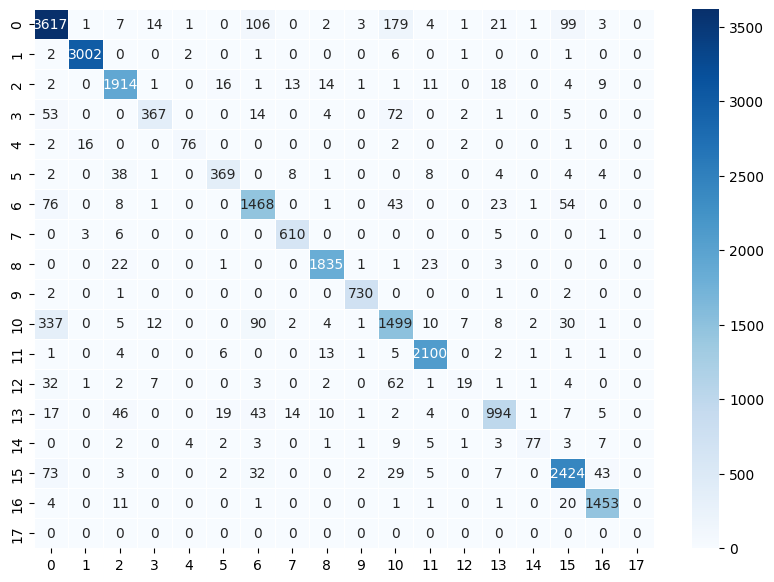

In [87]:
# test on the last model
trainer.test(model,masked_consonants_testloader)

In [88]:
# test on the best model based on val loss
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='masked-consonants',),
    vocab_size=masked_consonants_tokenizer.vocab_size,
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(18044, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9088233113288879     │
│         test_loss         │    0.32577255368232727    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9088233113288879, 'test_loss': 0.32577255368232727}]

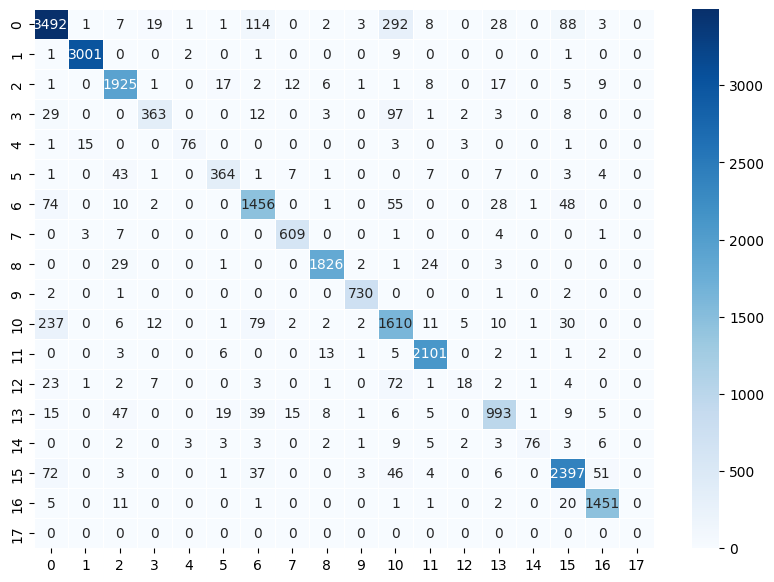

In [89]:
trainer.test(model,masked_consonants_testloader)

# Normal English without vowel words

## Prepare the dataset

In [90]:
train_dataset['tokens_without_vowel_words'] = train_dataset.progress_apply(lambda row: [token for token in row['tokens'] if not set(token).issubset('AaEeIiOoUu')],axis=1)
train_dataset

  0%|          | 0/11734 [00:00<?, ?it/s]

idx  \
0      weblog-juancole.com_juancole_20051126063000_EN...   
1      weblog-juancole.com_juancole_20051126063000_EN...   
2      weblog-juancole.com_juancole_20051126063000_EN...   
3      weblog-juancole.com_juancole_20051126063000_EN...   
4      weblog-juancole.com_juancole_20051126063000_EN...   
...                                                  ...   
12538                                reviews-319816-0025   
12539                                reviews-319816-0026   
12540                                reviews-319816-0027   
12541                                reviews-319816-0028   
12542                                reviews-319816-0029   

                                                    text  \
0      Al-Zaman : American forces killed Shaikh Abdul...   
1      [This killing of a respected cleric will be ca...   
2      DPA: Iraqi authorities announced that they had...   
3      Two of them were being run by 2 officials of t...   
4      The MoI in Iraq is equivalent to the US FBI, s...   
...                                                  ...   
12538  Of course, they couldn't call him either to as...   
12539  On Monday I called and again it was a big to-d...   
12540  Supposedly they will be holding it for me this...   
12541  The employees at this Sear's are completely ap...   
12542  I will never return there again (and now have ...   

                                                  tokens  \
0      [Al, -, Zaman, :, American, forces, killed, Sh...   
1      [[, This, killing, of, a, respected, cleric, w...   
2      [DPA, :, Iraqi, authorities, announced, that, ...   
3      [Two, of, them, were, being, run, by, 2, offic...   
4      [The, MoI, in, Iraq, is, equivalent, to, the, ...   
...                                                  ...   
12538  [Of, course, ,, they, could, n't, call, him, e...   
12539  [On, Monday, I, called, and, again, it, was, a...   
12540  [Supposedly, they, will, be, holding, it, for,...   
12541  [The, employees, at, this, Sear's, are, comple...   
12542  [I, will, never, return, there, again, (, and,...   

                                                  lemmas  \
0      [Al, -, Zaman, :, american, force, kill, Shaik...   
1      [[, this, killing, of, a, respected, cleric, w...   
2      [DPA, :, iraqi, authority, announce, that, the...   
3      [two, of, they, be, be, run, by, 2, official, ...   
4      [the, MoI, in, Iraq, be, equivalent, to, the, ...   
...                                                  ...   
12538  [of, course, ,, they, _, could, not, call, he,...   
12539  [on, Monday, I, call, and, again, it, be, a, b...   
12540  [supposedly, they, will, be, hold, it, for, I,...   
12541  [the, employee, at, this, Sears, be, completel...   
12542  [I, will, never, return, there, again, (, and,...   

                                                    upos  \
0      [10, 1, 10, 1, 6, 0, 15, 10, 10, 10, 1, 10, 1,...   
1      [1, 8, 0, 2, 8, 6, 0, 16, 16, 15, 11, 0, 2, 0,...   
2      [10, 1, 6, 0, 15, 5, 11, 16, 15, 2, 3, 6, 0, 1...   
3      [3, 2, 11, 16, 16, 15, 2, 3, 0, 2, 8, 10, 2, 8...   
4      [8, 10, 2, 10, 16, 6, 2, 8, 10, 10, 1, 13, 11,...   
...                                                  ...   
12538  [13, 13, 1, 11, 16, 7, 15, 11, 13, 7, 15, 2, 1...   
12539  [2, 10, 11, 15, 9, 13, 11, 16, 8, 6, 0, 1, 0, ...   
12540  [13, 11, 16, 16, 15, 11, 2, 11, 8, 0, 1, 9, 11...   
12541  [8, 0, 2, 8, 10, 16, 13, 6, 9, 11, 16, 7, 15, ...   
12542  [11, 16, 13, 15, 13, 13, 1, 9, 13, 15, 8, 6, 0...   

                                                    xpos  \
0      [NNP, HYPH, NNP, :, JJ, NNS, VBD, NNP, NNP, NN...   
1      [-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...   
2      [NNP, :, JJ, NNS, VBD, IN, PRP, VBD, VBN, RP, ...   
3      [CD, IN, PRP, VBD, VBG, VBN, IN, CD, NNS, IN, ...   
4      [DT, NNP, IN, NNP, VBZ, JJ, IN, DT, NNP, NNP, ...   
...                                                  ...   
12538  [RB, RB, ,, PRP, None

In [91]:
validation_dataset['tokens_without_vowel_words'] = validation_dataset.progress_apply(lambda row: [token for token in row['tokens'] if not set(token).issubset('AaEeIiOoUu')],axis=1)
validation_dataset

  0%|          | 0/1914 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_nominations_20041117172713...   
1     weblog-blogspot.com_nominations_20041117172713...   
2     weblog-blogspot.com_nominations_20041117172713...   
3     weblog-blogspot.com_nominations_20041117172713...   
4     weblog-blogspot.com_nominations_20041117172713...   
...                                                 ...   
1997                                reviews-202709-0003   
1998                                reviews-140302-0001   
1999                                reviews-140302-0002   
2000                                reviews-140302-0003   
2001                                reviews-140302-0004   

                                                   text  \
0                        From the AP comes this story :   
1     President Bush on Tuesday nominated two indivi...   
2     Bush nominated Jennifer M. Anderson for a 15-y...   
3                                                   ***   
4     Bush also nominated A. Noel Anketell Kramer fo...   
...                                                 ...   
1997  I recommend you to everyone in Calgary, as she...   
1998                                  5 star detail job   
1999  I took my Mustang here and it looked amazing a...   
2000  The paint and wheels looked like glass and the...   
2001  Also, they have great customer service and a v...   

                                                 tokens  \
0                [From, the, AP, comes, this, story, :]   
1     [President, Bush, on, Tuesday, nominated, two,...   
2     [Bush, nominated, Jennifer, M., Anderson, for,...   
3                                                 [***]   
4     [Bush, also, nominated, A., Noel, Anketell, Kr...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, took, my, Mustang, here, and, it, looked, ...   
2000  [The, paint, and, wheels, looked, like, glass,...   
2001  [Also, ,, they, have, great, customer, service...   

                                                 lemmas  \
0                 [from, the, AP, come, this, story, :]   
1     [President, Bush, on, Tuesday, nominate, two, ...   
2     [Bush, nominate, Jennifer, M., Anderson, for, ...   
3                                                 [***]   
4     [Bush, also, nominate, A., Noel, Anketell, Kra...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, take, my, Mustang, here, and, it, look, am...   
2000  [the, paint, and, wheel, look, like, glass, an...   
2001  [also, ,, they, have, great, customer, service...   

                                                   upos  \
0                               [2, 8, 10, 15, 8, 0, 1]   
1     [10, 10, 2, 10, 15, 3, 0, 7, 15, 15, 0, 2, 6, ...   
2     [10, 15, 10, 10, 10, 2, 8, 3, 1, 0, 0, 2, 6, 0...   
3                                                   [1]   
4     [10, 13, 15, 10, 10, 10, 10, 2, 8, 3, 1, 0, 0,...   
...                                                 ...   
1997  [11, 15, 11, 2, 11, 2, 10, 1, 5, 11, 16, 8, 0,...   
1998                                       [3, 0, 0, 0]   
1999  [11, 15, 11, 10, 13, 9, 11, 15, 6, 5, 11, 16, ...   
2000          [8, 0, 9, 0, 15, 2, 0, 9, 8, 0, 15, 6, 1]   
2001           [13, 1, 11, 15, 6, 0, 0, 9, 8, 13, 6, 0]   

                                                   xpos  \
0                         [IN, DT, NNP, VBZ, DT, NN, :]   
1     [NNP, NNP, IN, NNP, VBD, CD, NNS, TO, VB, VBG,...   
2     [NNP, VBD, NNP, NNP, NNP, IN, DT, CD, HYPH, NN...   
3                                                 [NFP]   
4     [NNP, RB, VBD, NNP, NNP, NNP, NNP, IN, DT, CD,...   
...                                                 ...   
1997  [PRP, VBP, PRP, IN, NN, IN, NNP, ,, IN, PRP, V...   
1998                               

In [92]:
test_dataset['tokens_without_vowel_words'] = test_dataset.progress_apply(lambda row: [token for token in row['tokens'] if not set(token).issubset('AaEeIiOoUu')],axis=1)
test_dataset

  0%|          | 0/1971 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_zentelligence_200404230002...   
1     weblog-blogspot.com_zentelligence_200404230002...   
2     weblog-blogspot.com_zentelligence_200404230002...   
3     weblog-blogspot.com_marketview_20050511222700_...   
4     weblog-blogspot.com_marketview_20050511222700_...   
...                                                 ...   
2072                                reviews-216281-0007   
2073                                reviews-216281-0008   
2074                                reviews-211933-0001   
2075                                reviews-211933-0002   
2076                                reviews-211933-0003   

                                                   text  \
0                 What if Google Morphed Into GoogleOS?   
1     What if Google expanded on its search-engine (...   
2             [via Microsoft Watch from Mary Jo Foley ]   
3     (And, by the way, is anybody else just a littl...   
4     This BuzzMachine post argues that Google's rus...   
...                                                 ...   
2072                                        thanks Rich   
2073                                            Seth K.   
2074  Deep tissue massage helps with pain in neck an...   
2075  Seth provides deep tissue massage which has si...   
2076  He listens and is excellent in diagnosing, add...   

                                                 tokens  \
0        [What, if, Google, Morphed, Into, GoogleOS, ?]   
1     [What, if, Google, expanded, on, its, search, ...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, And, ,, by, the, way, ,, is, anybody, else...   
4     [This, BuzzMachine, post, argues, that, Google...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [Deep, tissue, massage, helps, with, pain, in,...   
2075  [Seth, provides, deep, tissue, massage, which,...   
2076  [He, listens, and, is, excellent, in, diagnosi...   

                                                 lemmas  \
0          [what, if, Google, morph, into, GoogleOS, ?]   
1     [what, if, Google, expand, on, its, search, -,...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, and, ,, by, the, way, ,, be, anybody, else...   
4     [this, BuzzMachine, post, argue, that, _, Goog...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [deep, tissue, massage, help, with, pain, in, ...   
2075  [Seth, provide, deep, tissue, massage, which, ...   
2076  [he, listen, and, be, excellent, in, diagnose,...   

                                                   upos  \
0                             [11, 5, 10, 15, 2, 10, 1]   
1     [11, 5, 10, 15, 2, 11, 0, 1, 0, 1, 9, 13, 0, 1...   
2                      [1, 2, 10, 10, 2, 10, 10, 10, 1]   
3     [1, 9, 1, 2, 8, 0, 1, 16, 11, 6, 13, 8, 6, 0, ...   
4     [8, 10, 0, 15, 5, 10, 7, 0, 2, 0, 16, 15, 1, 1...   
...                                                 ...   
2072                                            [0, 10]   
2073                                        [10, 10, 1]   
2074                    [6, 0, 0, 15, 2, 0, 2, 0, 9, 0]   
2075  [10, 15, 6, 0, 0, 11, 16, 13, 15, 8, 0, 2, 11,...   
2076  [11, 15, 9, 16, 6, 5, 15, 1, 15, 9, 15, 8, 6, ...   

                                                   xpos  \
0                        [WP, IN, NNP, VBD, IN, NNP, .]   
1     [WP, IN, NNP, VBD, IN, PRP$, NN, HYPH, NN, -LR...   
2       [-LRB-, IN, NNP, NNP, IN, NNP, NNP, NNP, -RRB-]   
3     [-LRB-, CC, ,, IN, DT, NN, ,, VBZ, NN, JJ, RB,...   
4     [DT, NNP, NN, VBZ, IN, None, NNP, POS, NN, IN,...   
...                                                 ...   
2072                                          [NN, NNP]   
2073                               

## Prepare the tokenizer

In [93]:
tokenizer_without_vowel_words = tk.WordTokenizer(vocab_size=1_000_000)

In [94]:
tokenizer_without_vowel_words.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['tokens_without_vowel_words']))

Training WordTokenizer ...


In [95]:
tokenizer_without_vowel_words.vocab_size

19651

In [96]:
# test the tokenizer
tokenizer_without_vowel_words.tokenize('the hello is a good world , fractionally')

['the', 'hello', 'is', '<UNK>', 'good', 'world', ',', '<UNK>']

## tokenize and split

In [97]:
encoded_trainset_without_vowel_words,trainy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=train_dataset['tokens_without_vowel_words'],
    tags_list=train_dataset['constants_upos'],
    tokenizer=tokenizer_without_vowel_words,
  )
encoded_valset_without_vowel_words,valy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=validation_dataset['tokens_without_vowel_words'],
    tags_list=validation_dataset['constants_upos'],
    tokenizer=tokenizer_without_vowel_words,
  )
encoded_testset_without_vowel_words,testy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=test_dataset['tokens_without_vowel_words'],
    tags_list=test_dataset['constants_upos'],
    tokenizer=tokenizer_without_vowel_words,
  )
encoded_trainset_without_vowel_words.shape,trainy_without_vowel_words.shape,\
encoded_valset_without_vowel_words.shape,valy_without_vowel_words.shape,\
encoded_testset_without_vowel_words.shape,testy_without_vowel_words.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((11734, 200),
 (11734, 200),
 (1914, 200),
 (1914, 200),
 (1971, 200),
 (1971, 200))

In [98]:
# create tensor datasets
trainset_without_vowel_words = TensorDataset(torch.from_numpy(encoded_trainset_without_vowel_words), torch.from_numpy(trainy_without_vowel_words))
validset_without_vowel_words = TensorDataset(torch.from_numpy(encoded_valset_without_vowel_words), torch.from_numpy(valy_without_vowel_words))
testset_without_vowel_words = TensorDataset(torch.from_numpy(encoded_testset_without_vowel_words), torch.from_numpy(testy_without_vowel_words))

In [99]:
# create dataloaders
trainloader_without_vowel_words = DataLoader(trainset_without_vowel_words, shuffle=True, batch_size=batch_size,num_workers=4)
valloader_without_vowel_words = DataLoader(validset_without_vowel_words, shuffle=False, batch_size=batch_size,num_workers=4)
testloader_without_vowel_words = DataLoader(testset_without_vowel_words, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [100]:
model = LitBiLSTMModel(vocab_size=tokenizer_without_vowel_words.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(19651, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

In [101]:
trainer = train_model(
    model,
    train_dataloader=trainloader_without_vowel_words,
    val_dataloader=valloader_without_vowel_words,
    text_type='all-characters-without-vowel-words',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.900453805923462     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 10.1 M
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 4.6 K 
---------------------------------------------------------
16.4 M    Trainable params
0         Non-trainable params
16.4 M    Total params
65.495    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00020: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9140507578849792     │
│         test_loss         │    0.3148462474346161     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9140507578849792, 'test_loss': 0.3148462474346161}]

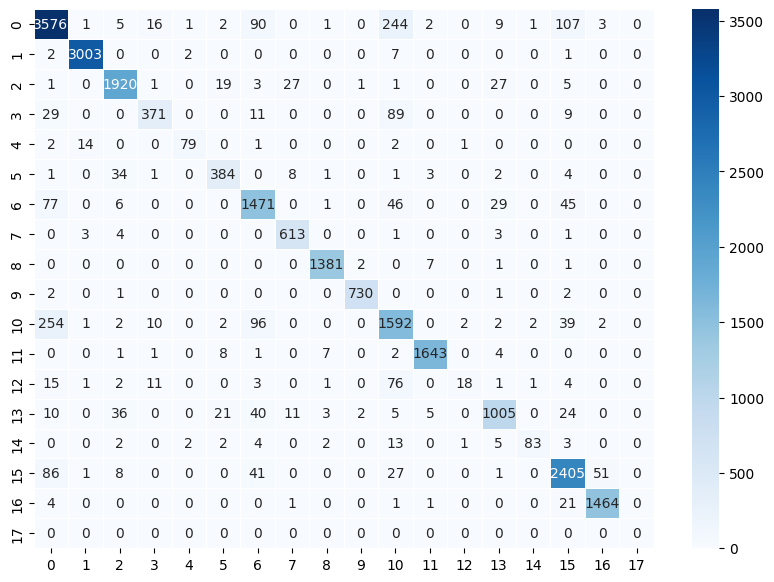

In [102]:
# test on the last model
trainer.test(model,testloader_without_vowel_words)

In [103]:
# test on teh best model according to val accuracy
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='all-characters-without-vowel-words',),
    vocab_size=tokenizer_without_vowel_words.vocab_size
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(19651, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9119085669517517     │
│         test_loss         │    0.31087449193000793    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9119085669517517, 'test_loss': 0.31087449193000793}]

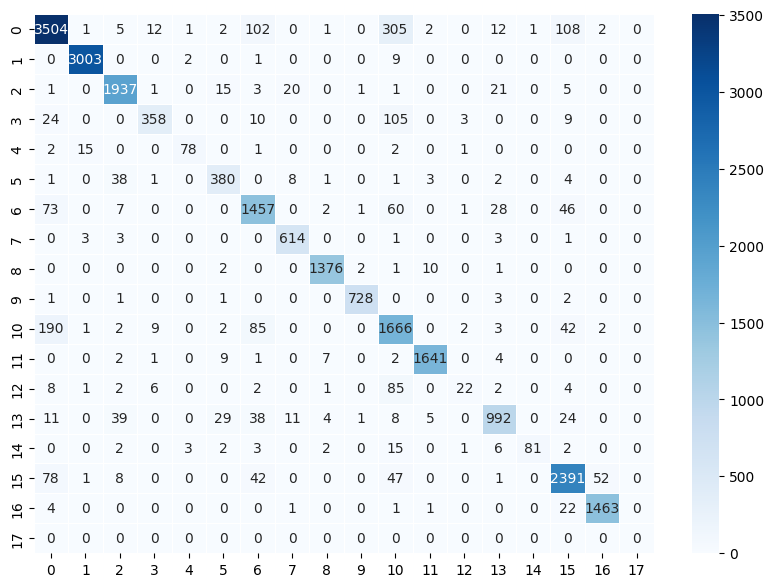

In [104]:
trainer.test(model,testloader_without_vowel_words)

# Masked Consontants without vowel words

## Prepare the dataset

In [105]:
train_dataset['masked_tokens_without_vowel_words'] = train_dataset['tokens_without_vowel_words'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
train_dataset

  0%|          | 0/11734 [00:00<?, ?it/s]

idx  \
0      weblog-juancole.com_juancole_20051126063000_EN...   
1      weblog-juancole.com_juancole_20051126063000_EN...   
2      weblog-juancole.com_juancole_20051126063000_EN...   
3      weblog-juancole.com_juancole_20051126063000_EN...   
4      weblog-juancole.com_juancole_20051126063000_EN...   
...                                                  ...   
12538                                reviews-319816-0025   
12539                                reviews-319816-0026   
12540                                reviews-319816-0027   
12541                                reviews-319816-0028   
12542                                reviews-319816-0029   

                                                    text  \
0      Al-Zaman : American forces killed Shaikh Abdul...   
1      [This killing of a respected cleric will be ca...   
2      DPA: Iraqi authorities announced that they had...   
3      Two of them were being run by 2 officials of t...   
4      The MoI in Iraq is equivalent to the US FBI, s...   
...                                                  ...   
12538  Of course, they couldn't call him either to as...   
12539  On Monday I called and again it was a big to-d...   
12540  Supposedly they will be holding it for me this...   
12541  The employees at this Sear's are completely ap...   
12542  I will never return there again (and now have ...   

                                                  tokens  \
0      [Al, -, Zaman, :, American, forces, killed, Sh...   
1      [[, This, killing, of, a, respected, cleric, w...   
2      [DPA, :, Iraqi, authorities, announced, that, ...   
3      [Two, of, them, were, being, run, by, 2, offic...   
4      [The, MoI, in, Iraq, is, equivalent, to, the, ...   
...                                                  ...   
12538  [Of, course, ,, they, could, n't, call, him, e...   
12539  [On, Monday, I, called, and, again, it, was, a...   
12540  [Supposedly, they, will, be, holding, it, for,...   
12541  [The, employees, at, this, Sear's, are, comple...   
12542  [I, will, never, return, there, again, (, and,...   

                                                  lemmas  \
0      [Al, -, Zaman, :, american, force, kill, Shaik...   
1      [[, this, killing, of, a, respected, cleric, w...   
2      [DPA, :, iraqi, authority, announce, that, the...   
3      [two, of, they, be, be, run, by, 2, official, ...   
4      [the, MoI, in, Iraq, be, equivalent, to, the, ...   
...                                                  ...   
12538  [of, course, ,, they, _, could, not, call, he,...   
12539  [on, Monday, I, call, and, again, it, be, a, b...   
12540  [supposedly, they, will, be, hold, it, for, I,...   
12541  [the, employee, at, this, Sears, be, completel...   
12542  [I, will, never, return, there, again, (, and,...   

                                                    upos  \
0      [10, 1, 10, 1, 6, 0, 15, 10, 10, 10, 1, 10, 1,...   
1      [1, 8, 0, 2, 8, 6, 0, 16, 16, 15, 11, 0, 2, 0,...   
2      [10, 1, 6, 0, 15, 5, 11, 16, 15, 2, 3, 6, 0, 1...   
3      [3, 2, 11, 16, 16, 15, 2, 3, 0, 2, 8, 10, 2, 8...   
4      [8, 10, 2, 10, 16, 6, 2, 8, 10, 10, 1, 13, 11,...   
...                                                  ...   
12538  [13, 13, 1, 11, 16, 7, 15, 11, 13, 7, 15, 2, 1...   
12539  [2, 10, 11, 15, 9, 13, 11, 16, 8, 6, 0, 1, 0, ...   
12540  [13, 11, 16, 16, 15, 11, 2, 11, 8, 0, 1, 9, 11...   
12541  [8, 0, 2, 8, 10, 16, 13, 6, 9, 11, 16, 7, 15, ...   
12542  [11, 16, 13, 15, 13, 13, 1, 9, 13, 15, 8, 6, 0...   

                                                    xpos  \
0      [NNP, HYPH, NNP, :, JJ, NNS, VBD, NNP, NNP, NN...   
1      [-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...   
2      [NNP, :, JJ, NNS, VBD, IN, PRP, VBD, VBN, RP, ...   
3      [CD, IN, PRP, VBD, VBG, VBN, IN, CD, NNS, IN, ...   
4      [DT, NNP, IN, NNP, VBZ, JJ, IN, DT, NNP, NNP, ...   
...                                                  ...   
12538  [RB, RB, ,, PRP, None

In [106]:
validation_dataset['masked_tokens_without_vowel_words'] = validation_dataset['tokens_without_vowel_words'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
validation_dataset

  0%|          | 0/1914 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_nominations_20041117172713...   
1     weblog-blogspot.com_nominations_20041117172713...   
2     weblog-blogspot.com_nominations_20041117172713...   
3     weblog-blogspot.com_nominations_20041117172713...   
4     weblog-blogspot.com_nominations_20041117172713...   
...                                                 ...   
1997                                reviews-202709-0003   
1998                                reviews-140302-0001   
1999                                reviews-140302-0002   
2000                                reviews-140302-0003   
2001                                reviews-140302-0004   

                                                   text  \
0                        From the AP comes this story :   
1     President Bush on Tuesday nominated two indivi...   
2     Bush nominated Jennifer M. Anderson for a 15-y...   
3                                                   ***   
4     Bush also nominated A. Noel Anketell Kramer fo...   
...                                                 ...   
1997  I recommend you to everyone in Calgary, as she...   
1998                                  5 star detail job   
1999  I took my Mustang here and it looked amazing a...   
2000  The paint and wheels looked like glass and the...   
2001  Also, they have great customer service and a v...   

                                                 tokens  \
0                [From, the, AP, comes, this, story, :]   
1     [President, Bush, on, Tuesday, nominated, two,...   
2     [Bush, nominated, Jennifer, M., Anderson, for,...   
3                                                 [***]   
4     [Bush, also, nominated, A., Noel, Anketell, Kr...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, took, my, Mustang, here, and, it, looked, ...   
2000  [The, paint, and, wheels, looked, like, glass,...   
2001  [Also, ,, they, have, great, customer, service...   

                                                 lemmas  \
0                 [from, the, AP, come, this, story, :]   
1     [President, Bush, on, Tuesday, nominate, two, ...   
2     [Bush, nominate, Jennifer, M., Anderson, for, ...   
3                                                 [***]   
4     [Bush, also, nominate, A., Noel, Anketell, Kra...   
...                                                 ...   
1997  [I, recommend, you, to, everyone, in, Calgary,...   
1998                             [5, star, detail, job]   
1999  [I, take, my, Mustang, here, and, it, look, am...   
2000  [the, paint, and, wheel, look, like, glass, an...   
2001  [also, ,, they, have, great, customer, service...   

                                                   upos  \
0                               [2, 8, 10, 15, 8, 0, 1]   
1     [10, 10, 2, 10, 15, 3, 0, 7, 15, 15, 0, 2, 6, ...   
2     [10, 15, 10, 10, 10, 2, 8, 3, 1, 0, 0, 2, 6, 0...   
3                                                   [1]   
4     [10, 13, 15, 10, 10, 10, 10, 2, 8, 3, 1, 0, 0,...   
...                                                 ...   
1997  [11, 15, 11, 2, 11, 2, 10, 1, 5, 11, 16, 8, 0,...   
1998                                       [3, 0, 0, 0]   
1999  [11, 15, 11, 10, 13, 9, 11, 15, 6, 5, 11, 16, ...   
2000          [8, 0, 9, 0, 15, 2, 0, 9, 8, 0, 15, 6, 1]   
2001           [13, 1, 11, 15, 6, 0, 0, 9, 8, 13, 6, 0]   

                                                   xpos  \
0                         [IN, DT, NNP, VBZ, DT, NN, :]   
1     [NNP, NNP, IN, NNP, VBD, CD, NNS, TO, VB, VBG,...   
2     [NNP, VBD, NNP, NNP, NNP, IN, DT, CD, HYPH, NN...   
3                                                 [NFP]   
4     [NNP, RB, VBD, NNP, NNP, NNP, NNP, IN, DT, CD,...   
...                                                 ...   
1997  [PRP, VBP, PRP, IN, NN, IN, NNP, ,, IN, PRP, V...   
1998                               

In [107]:
test_dataset['masked_tokens_without_vowel_words'] = test_dataset['tokens_without_vowel_words'].progress_apply(lambda tokens_list: mask_vowels(tokens_list,mask="a"))
test_dataset

  0%|          | 0/1971 [00:00<?, ?it/s]

idx  \
0     weblog-blogspot.com_zentelligence_200404230002...   
1     weblog-blogspot.com_zentelligence_200404230002...   
2     weblog-blogspot.com_zentelligence_200404230002...   
3     weblog-blogspot.com_marketview_20050511222700_...   
4     weblog-blogspot.com_marketview_20050511222700_...   
...                                                 ...   
2072                                reviews-216281-0007   
2073                                reviews-216281-0008   
2074                                reviews-211933-0001   
2075                                reviews-211933-0002   
2076                                reviews-211933-0003   

                                                   text  \
0                 What if Google Morphed Into GoogleOS?   
1     What if Google expanded on its search-engine (...   
2             [via Microsoft Watch from Mary Jo Foley ]   
3     (And, by the way, is anybody else just a littl...   
4     This BuzzMachine post argues that Google's rus...   
...                                                 ...   
2072                                        thanks Rich   
2073                                            Seth K.   
2074  Deep tissue massage helps with pain in neck an...   
2075  Seth provides deep tissue massage which has si...   
2076  He listens and is excellent in diagnosing, add...   

                                                 tokens  \
0        [What, if, Google, Morphed, Into, GoogleOS, ?]   
1     [What, if, Google, expanded, on, its, search, ...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, And, ,, by, the, way, ,, is, anybody, else...   
4     [This, BuzzMachine, post, argues, that, Google...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [Deep, tissue, massage, helps, with, pain, in,...   
2075  [Seth, provides, deep, tissue, massage, which,...   
2076  [He, listens, and, is, excellent, in, diagnosi...   

                                                 lemmas  \
0          [what, if, Google, morph, into, GoogleOS, ?]   
1     [what, if, Google, expand, on, its, search, -,...   
2     [[, via, Microsoft, Watch, from, Mary, Jo, Fol...   
3     [(, and, ,, by, the, way, ,, be, anybody, else...   
4     [this, BuzzMachine, post, argue, that, _, Goog...   
...                                                 ...   
2072                                     [thanks, Rich]   
2073                                       [Seth, K, .]   
2074  [deep, tissue, massage, help, with, pain, in, ...   
2075  [Seth, provide, deep, tissue, massage, which, ...   
2076  [he, listen, and, be, excellent, in, diagnose,...   

                                                   upos  \
0                             [11, 5, 10, 15, 2, 10, 1]   
1     [11, 5, 10, 15, 2, 11, 0, 1, 0, 1, 9, 13, 0, 1...   
2                      [1, 2, 10, 10, 2, 10, 10, 10, 1]   
3     [1, 9, 1, 2, 8, 0, 1, 16, 11, 6, 13, 8, 6, 0, ...   
4     [8, 10, 0, 15, 5, 10, 7, 0, 2, 0, 16, 15, 1, 1...   
...                                                 ...   
2072                                            [0, 10]   
2073                                        [10, 10, 1]   
2074                    [6, 0, 0, 15, 2, 0, 2, 0, 9, 0]   
2075  [10, 15, 6, 0, 0, 11, 16, 13, 15, 8, 0, 2, 11,...   
2076  [11, 15, 9, 16, 6, 5, 15, 1, 15, 9, 15, 8, 6, ...   

                                                   xpos  \
0                        [WP, IN, NNP, VBD, IN, NNP, .]   
1     [WP, IN, NNP, VBD, IN, PRP$, NN, HYPH, NN, -LR...   
2       [-LRB-, IN, NNP, NNP, IN, NNP, NNP, NNP, -RRB-]   
3     [-LRB-, CC, ,, IN, DT, NN, ,, VBZ, NN, JJ, RB,...   
4     [DT, NNP, NN, VBZ, IN, None, NNP, POS, NN, IN,...   
...                                                 ...   
2072                                          [NN, NNP]   
2073                               

## Prepare the tokenizer

In [108]:
masked_tokenizer_without_vowel_words = tk.WordTokenizer(vocab_size=1_000_000)

In [109]:
masked_tokenizer_without_vowel_words.train(text='\n'.join(' '.join(tokens for tokens in sample) for sample in train_dataset['masked_tokens_without_vowel_words']))

Training WordTokenizer ...


In [110]:
masked_tokenizer_without_vowel_words.vocab_size

18040

In [111]:
# test the tokenizer
masked_tokenizer_without_vowel_words.tokenize('tha halla as a gaad warld , fractaanally')

['tha', 'halla', 'as', '<UNK>', 'gaad', 'warld', ',', '<UNK>']

## tokenize and split

In [112]:
masked_encoded_trainset_without_vowel_words,masked_trainy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=train_dataset['masked_tokens_without_vowel_words'],
    tags_list=train_dataset['constants_upos'],
    tokenizer=masked_tokenizer_without_vowel_words,
  )
masked_encoded_valset_without_vowel_words,masked_valy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=validation_dataset['masked_tokens_without_vowel_words'],
    tags_list=validation_dataset['constants_upos'],
    tokenizer=masked_tokenizer_without_vowel_words,
  )
masked_encoded_testset_without_vowel_words,masked_testy_without_vowel_words = create_features_from_tokens_list(
    tokens_list=test_dataset['masked_tokens_without_vowel_words'],
    tags_list=test_dataset['constants_upos'],
    tokenizer=masked_tokenizer_without_vowel_words,
  )
masked_encoded_trainset_without_vowel_words.shape,masked_trainy_without_vowel_words.shape,\
masked_encoded_valset_without_vowel_words.shape,masked_valy_without_vowel_words.shape,\
masked_encoded_testset_without_vowel_words.shape,masked_testy_without_vowel_words.shape

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

((11734, 200),
 (11734, 200),
 (1914, 200),
 (1914, 200),
 (1971, 200),
 (1971, 200))

In [113]:
# create tensor datasets
masked_trainset_without_vowel_words = TensorDataset(torch.from_numpy(masked_encoded_trainset_without_vowel_words), torch.from_numpy(masked_trainy_without_vowel_words))
masked_validset_without_vowel_words = TensorDataset(torch.from_numpy(masked_encoded_valset_without_vowel_words), torch.from_numpy(masked_valy_without_vowel_words))
masked_testset_without_vowel_words = TensorDataset(torch.from_numpy(masked_encoded_testset_without_vowel_words), torch.from_numpy(masked_testy_without_vowel_words))

In [114]:
# create dataloaders
masked_trainloader_without_vowel_words = DataLoader(masked_trainset_without_vowel_words, shuffle=True, batch_size=batch_size,num_workers=4)
masked_valloader_without_vowel_words = DataLoader(masked_validset_without_vowel_words, shuffle=False, batch_size=batch_size,num_workers=4)
masked_testloader_without_vowel_words = DataLoader(masked_testset_without_vowel_words, shuffle=False, batch_size=batch_size,num_workers=4)

## build and train the model

In [115]:
model = LitBiLSTMModel(vocab_size=masked_tokenizer_without_vowel_words.vocab_size)
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(18040, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

In [116]:
trainer = train_model(
    model,
    train_dataloader=masked_trainloader_without_vowel_words,
    val_dataloader=masked_valloader_without_vowel_words,
    text_type='masked-consonants-without-vowel-words',
  )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │     2.90075945854187      │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | train_accuracy    | MulticlassAccuracy | 0     
1 | val_accuracy      | MulticlassAccuracy | 0     
2 | test_accuracy     | MulticlassAccuracy | 0     
3 | embedding         | Embedding          | 9.2 M 
4 | lstm              | LSTM               | 6.3 M 
5 | dropout           | Dropout            | 0     
6 | embedding_dropout | Dropout            | 0     
7 | fc                | Linear             | 4.6 K 
---------------------------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
62.196    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 6.2500e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00027: reducing learning rate of group 0 to 3.1250e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8921113014221191     │
│         test_loss         │    0.37847018241882324    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8921113014221191, 'test_loss': 0.37847018241882324}]

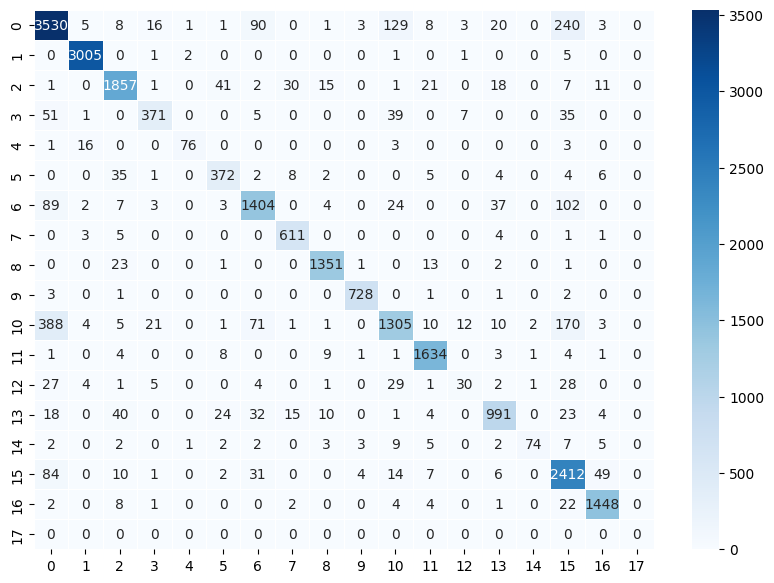

In [117]:
# test on the last model
trainer.test(model,masked_testloader_without_vowel_words)

In [118]:
# test on teh best model according to val accuracy
model = LitBiLSTMModel.load_from_checkpoint(
    get_best_checkpoint(text_type='masked-consonants-without-vowel-words',),
    vocab_size=masked_tokenizer_without_vowel_words.vocab_size
    )
model

LitBiLSTMModel(
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
  (embedding): Embedding(18040, 512)
  (lstm): LSTM(512, 256, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=18, bias=True)
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8929398059844971     │
│         test_loss         │    0.3725683093070984     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8929398059844971, 'test_loss': 0.3725683093070984}]

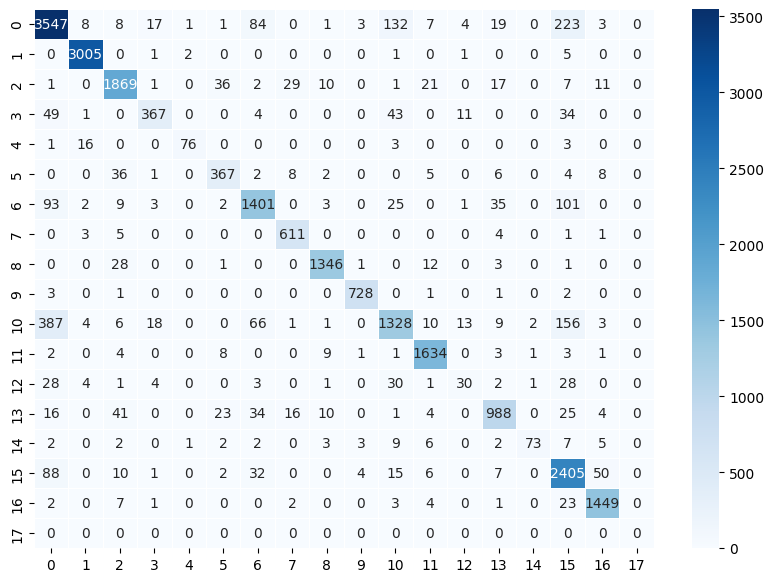

In [119]:
trainer.test(model,masked_testloader_without_vowel_words)